In [2]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os

# TO USE A DATABASE OTHER THAN SQLITE, USE THIS LINE
# Note that this is necessary for parallel execution amongst other things...
# os.environ['SNORKELDB'] = 'postgres:///snorkel-intro'

from snorkel import SnorkelSession
session = SnorkelSession()

# Here, we just set how many documents we'll process for automatic testing- you can safely ignore this!
n_docs = 500 if 'CI' in os.environ else 2591

from snorkel.models import candidate_subclass

Spouse = candidate_subclass('Spouse', ['person1', 'person2'])

train_cands = session.query(Spouse).filter(Spouse.split == 0).order_by(Spouse.id).all()
dev_cands   = session.query(Spouse).filter(Spouse.split == 1).order_by(Spouse.id).all()
test_cands  = session.query(Spouse).filter(Spouse.split == 2).order_by(Spouse.id).all()
print(len(dev_cands))

2814


In [3]:
from util import load_external_labels

# %time load_external_labels(session, Spouse, annotator_name='gold')

from snorkel.annotations import load_gold_labels

#L_gold_dev  = load_gold_labels(session, annotator_name='gold', split=1, zero_one=True)
#L_gold_test = load_gold_labels(session, annotator_name='gold', split=2, zero_one=True)

# L_gold_dev  = load_gold_labels(session, annotator_name='gold', split=1)
# L_gold_test = load_gold_labels(session, annotator_name='gold', split=2)
L_gold_dev  = load_gold_labels(session, annotator_name='gold', split=1, zero_one=True)
# gold_labels_dev = [L[0,0] if L[0,0]==1 else -1 for L in L_gold_dev]
gold_labels_dev = [L[0,0] for L in L_gold_dev]


from snorkel.learning.utils import MentionScorer

Instructions for updating:
Use the retry module or similar alternatives.


In [9]:
#gold_labels_dev = [x[0,0] for x in L_gold_dev.todense()]
#for i,L in enumerate(gold_labels_dev):
#    print(i,gold_labels_dev[i])

# gold_labels_dev = []
# for i,L in enumerate(L_gold_dev):
#     gold_labels_dev.append(L[0,0])
    
# gold_labels_test = []
# for i,L in enumerate(L_gold_test):
#     gold_labels_test.append(L[0,0])
    
# print(len(gold_labels_dev),len(gold_labels_test))
# print(gold_labels_dev.count(1),gold_labels_dev.count(-1))
# print(len(gold_labels_dev))

print(gold_labels_dev.count(1),gold_labels_dev.count(0))
print(len(gold_labels_dev))

189 2625
2814


In [96]:
from gensim.parsing.preprocessing import STOPWORDS
import gensim.matutils as gm

from gensim.models.keyedvectors import KeyedVectors

# Load pretrained model (since intermediate data is not included, the model cannot be refined with additional data)
model = KeyedVectors.load_word2vec_format('../../../snorkel/tutorials/glove_w2v.txt', binary=False)  # C binary format


wordvec_unavailable= set()
def write_to_file(wordvec_unavailable):
    with open("wordvec_unavailable.txt","w") as f:
        for word in wordvec_unavailable:
            f.write(word+"\n")

def preprocess(tokens):
    btw_words = [word for word in tokens if word not in STOPWORDS]
    btw_words = [word for word in btw_words if word.isalpha()]
    return btw_words

def get_word_vectors(btw_words): # returns vector of embeddings of words
    word_vectors= []
    for word in btw_words:
        try:
            word_v = np.array(model[word])
            word_v = word_v.reshape(len(word_v),1)
            #print(word_v.shape)
            word_vectors.append(model[word])
        except:
            wordvec_unavailable.add(word)
    return word_vectors

def get_similarity(word_vectors,target_word): # sent(list of word vecs) to word similarity
    similarity = 0
    target_word_vector = 0
    try:
        target_word_vector = model[target_word]
    except:
        wordvec_unavailable.add(target_word+" t")
        return similarity
    target_word_sparse = gm.any2sparse(target_word_vector,eps=1e-09)
    for wv in word_vectors:
        wv_sparse = gm.any2sparse(wv, eps=1e-09)
        similarity = max(similarity,gm.cossim(wv_sparse,target_word_sparse))
    return similarity


In [11]:
# ####### Discrete ##########

# spouses = {'spouse', 'wife', 'husband', 'ex-wife', 'ex-husband'}
# family = {'father', 'mother', 'sister', 'brother', 'son', 'daughter',
#               'grandfather', 'grandmother', 'uncle', 'aunt', 'cousin'}
# family = family | {f + '-in-law' for f in family}
# other = {'boyfriend', 'girlfriend' 'boss', 'employee', 'secretary', 'co-worker'}

# # Helper function to get last name
# def last_name(s):
#     name_parts = s.split(' ')
#     return name_parts[-1] if len(name_parts) > 1 else None    

# def LF_husband_wife(c):
#     return (1,1) if len(spouses.intersection(get_between_tokens(c))) > 0 else (0,0)

# def LF_husband_wife_left_window(c):
#     if len(spouses.intersection(get_left_tokens(c[0], window=2))) > 0:
#         return (1,1)
#     elif len(spouses.intersection(get_left_tokens(c[1], window=2))) > 0:
#         return (1,1)
#     else:
#         return (0,0)
    
# def LF_same_last_name(c):
#     p1_last_name = last_name(c.person1.get_span())
#     p2_last_name = last_name(c.person2.get_span())
#     if p1_last_name and p2_last_name and p1_last_name == p2_last_name:
#         if c.person1.get_span() != c.person2.get_span():
#             return (1,1)
#     return (0,0)

# def LF_no_spouse_in_sentence(c):
#     return (-1,1) if np.random.rand() < 0.75 and len(spouses.intersection(c.get_parent().words)) == 0 else (0,0)

# def LF_and_married(c):
#     return (1,1) if 'and' in get_between_tokens(c) and 'married' in get_right_tokens(c) else (0,0)
    
# def LF_familial_relationship(c):
#     return (-1,1) if len(family.intersection(get_between_tokens(c))) > 0 else (0,0)

# def LF_family_left_window(c):
#     if len(family.intersection(get_left_tokens(c[0], window=2))) > 0:
#         return (-1,1)
#     elif len(family.intersection(get_left_tokens(c[1], window=2))) > 0:
#         return (-1,1)
#     else:
#         return (0,0)

# def LF_other_relationship(c):
#     return (-1,1) if len(other.intersection(get_between_tokens(c))) > 0 else (0,0)


# import bz2

# # Function to remove special characters from text
# def strip_special(s):
#     return ''.join(c for c in s if ord(c) < 128)

# # Read in known spouse pairs and save as set of tuples
# with bz2.BZ2File('data/spouses_dbpedia.csv.bz2', 'rb') as f:
#     known_spouses = set(
#         tuple(strip_special(x.decode('utf-8')).strip().split(',')) for x in f.readlines()
#     )
# # Last name pairs for known spouses
# last_names = set([(last_name(x), last_name(y)) for x, y in known_spouses if last_name(x) and last_name(y)])
    
# def LF_distant_supervision(c):
#     p1, p2 = c.person1.get_span(), c.person2.get_span()
#     return (1,1) if (p1, p2) in known_spouses or (p2, p1) in known_spouses else (0,0)

# def LF_distant_supervision_last_names(c):
#     p1, p2 = c.person1.get_span(), c.person2.get_span()
#     p1n, p2n = last_name(p1), last_name(p2)
#     return (1,1) if (p1 != p2) and ((p1n, p2n) in last_names or (p2n, p1n) in last_names) else (0,0)


# LFs = [
#     LF_distant_supervision, LF_distant_supervision_last_names, 
#     LF_husband_wife, LF_husband_wife_left_window, LF_same_last_name,
#     LF_no_spouse_in_sentence, LF_and_married, LF_familial_relationship, 
#     LF_family_left_window, LF_other_relationship
# ]

In [9]:
##### Continuous ################


import re
from snorkel.lf_helpers import (
    get_left_tokens, get_right_tokens, get_between_tokens,
    get_text_between, get_tagged_text,
)


spouses = {'spouse', 'wife', 'husband', 'ex-wife', 'ex-husband'}
family = {'father', 'mother', 'sister', 'brother', 'son', 'daughter',
              'grandfather', 'grandmother', 'uncle', 'aunt', 'cousin'}
family = family | {f + '-in-law' for f in family}
other = {'boyfriend', 'girlfriend' 'boss', 'employee', 'secretary', 'co-worker'}

# Helper function to get last name
def last_name(s):
    name_parts = s.split(' ')
    return name_parts[-1] if len(name_parts) > 1 else None    

def LF_husband_wife(c):
    global LF_Threshold
    sc = 0
    word_vectors = get_word_vectors(preprocess(get_between_tokens(c)))
    for sw in spouses:
        sc=max(sc,get_similarity(word_vectors,sw))
    return (1,sc)

def LF_husband_wife_left_window(c):
    global LF_Threshold
    sc_1 = 0
    word_vectors = get_word_vectors(preprocess(get_left_tokens(c[0])))
    for sw in spouses:
        sc_1=max(sc_1,get_similarity(word_vectors,sw))
        
    sc_2 = 0
    word_vectors = get_word_vectors(preprocess(get_left_tokens(c[1])))
    for sw in spouses:
        sc_2=max(sc_2,get_similarity(word_vectors,sw))
    return(1,max(sc_1,sc_2))
    
def LF_same_last_name(c):
    p1_last_name = last_name(c.person1.get_span())
    p2_last_name = last_name(c.person2.get_span())
    if p1_last_name and p2_last_name and p1_last_name == p2_last_name:
        if c.person1.get_span() != c.person2.get_span():
            return (1,1)
    return (0,0)

def LF_no_spouse_in_sentence(c):
    return (-1,0.75) if np.random.rand() < 0.75 and len(spouses.intersection(c.get_parent().words)) == 0 else (0,0)

def LF_and_married(c):
    global LF_Threshold
    word_vectors = get_word_vectors(preprocess(get_right_tokens(c)))
    sc = get_similarity(word_vectors,'married')
    
    if 'and' in get_between_tokens(c):
        return (1,sc)
    else:
        return (0,0)

def LF_familial_relationship(c):
    sc = 0
    word_vectors = get_word_vectors(preprocess(get_between_tokens(c)))
    for fw in family:
        sc=max(sc,get_similarity(word_vectors,fw))
        
    return (-1,sc) 

def LF_family_left_window(c):
    sc_1 = 0
    word_vectors = get_word_vectors(preprocess(get_left_tokens(c[0])))
    for fw in family:
        sc_1=max(sc_1,get_similarity(word_vectors,fw))
        
    sc_2 = 0
    word_vectors = get_word_vectors(preprocess(get_left_tokens(c[1])))
    for fw in family:
        sc_2=max(sc_2,get_similarity(word_vectors,fw))
        
    return (-1,max(sc_1,sc_2))

def LF_other_relationship(c):
    sc = 0
    word_vectors = get_word_vectors(preprocess(get_between_tokens(c)))
    for ow in other:
        sc=max(sc,get_similarity(word_vectors,ow))
        
    return (-1,sc) 

# def LF_other_relationship_left_window(c):
#     sc = 0
#     word_vectors = get_word_vectors(preprocess(get_left_tokens(c)))
#     for ow in other:
#         sc=max(sc,get_similarity(word_vectors,ow))
#     return (-1,sc) 

import bz2

# Function to remove special characters from text
def strip_special(s):
    return ''.join(c for c in s if ord(c) < 128)

# # Read in known spouse pairs and save as set of tuples
# with bz2.BZ2File('data/spouses_dbpedia.csv.bz2', 'rb') as f:
#     known_spouses = set(
#         tuple(strip_special(x).strip().split(',')) for x in f.readlines()
#     )
# # Last name pairs for known spouses
# last_names = set([(last_name(x), last_name(y)) for x, y in known_spouses if last_name(x) and last_name(y)])
    
def LF_distant_supervision(c):
    p1, p2 = c.person1.get_span(), c.person2.get_span()
    return (1,1) if (p1, p2) in known_spouses or (p2, p1) in known_spouses else (0,0)

def LF_distant_supervision_last_names(c):
    p1, p2 = c.person1.get_span(), c.person2.get_span()
    p1n, p2n = last_name(p1), last_name(p2)
    return (1,1) if (p1 != p2) and ((p1n, p2n) in last_names or (p2n, p1n) in last_names) else (0,1)

import numpy as np

# def LF_Three_Lists_Left_Window(c):
#     global softmax_Threshold
#     c1,s1 = LF_husband_wife_left_window(c)
#     c2,s2 = LF_family_left_window(c)
#     c3,s3 = LF_other_relationship_left_window(c)
#     sc = np.array([s1,s2,s3])
#     c = [c1,c2,c3]
#     sharp_param = 1.5
#     prob_sc = np.exp(sc * sharp_param - np.max(sc))
#     prob_sc = prob_sc / np.sum(prob_sc)
#     #print 'Left:',s1,s2,s3,prob_sc
    
#     if s1==s2 or s3==s1:
#         return (0,0)
#     return c[np.argmax(prob_sc)],1

# def LF_Three_Lists_Between_Words(c):
#     global softmax_Threshold
#     c1,s1 = LF_husband_wife(c)
#     c2,s2 = LF_familial_relationship(c)
#     c3,s3 = LF_other_relationship(c)
#     sc = np.array([s1,s2,s3])
#     c = [c1,c2,c3]
#     sharp_param = 1.5
    
#     prob_sc = np.exp(sc * sharp_param - np.max(sc))
#     prob_sc = prob_sc / np.sum(prob_sc)
#     #print 'BW:',s1,s2,s3,prob_sc
#     if s1==s2 or s3==s1:
#         return (0,0)
#     return c[np.argmax(prob_sc)],1
    
LFs = [
    LF_distant_supervision, LF_distant_supervision_last_names, 
    LF_husband_wife, LF_husband_wife_left_window, LF_same_last_name,
    LF_no_spouse_in_sentence, LF_and_married, LF_familial_relationship, 
    LF_family_left_window, LF_other_relationship
]

In [99]:
''' output:

    [[[L_x1],[S_x1]],
     [[L_x2],[S_x2]],
     ......
     ......
    ]

'''
def get_L_S_Tensor(cands): 
    
    L_S = []
    for i,ci in enumerate(cands):
        L_S_ci=[]
        L=[]
        S=[]
        for LF in LFs:
            #print LF.__name__
            l,s = LF(ci)
            L.append(l)
            S.append((s+1)/2)  #to scale scores in [0,1] 
        L_S_ci.append(L)
        L_S_ci.append(S)
        L_S.append(L_S_ci) 
        if(i%500==0 and i!=0):
            print(str(i)+'data points labelled in',(time.time() - start_time)/60,'mins')
    return L_S


In [100]:
# import matplotlib.pyplot as plt
import time
import numpy as np
start_time = time.time()

lt = time.localtime()

print("started at: {}-{}-{}, {}:{}:{}".format(lt.tm_mday,lt.tm_mon,lt.tm_year,lt.tm_hour,lt.tm_min,lt.tm_sec))

dev_L_S = get_L_S_Tensor(dev_cands)

np.save("dev_L_S_smooth",np.array(dev_L_S))

train_L_S = get_L_S_Tensor(train_cands)
np.save("train_L_S_smooth",np.array(train_L_S))

print("--- %s seconds ---" % (time.time() - start_time))

# test_L_S = get_L_S_Tensor(test_cands)
# pkl.dump(test_L_S,open("test_L_S.p","wb"))

started at: 9-5-2018, 10:41:55
500data points labelled in 0.7188430507977803 mins
1000data points labelled in 1.3335495034853617 mins
1500data points labelled in 1.917067794005076 mins
2000data points labelled in 2.519752260049184 mins
2500data points labelled in 3.1769800662994383 mins
500data points labelled in 4.174797224998474 mins
1000data points labelled in 4.797278384367625 mins
1500data points labelled in 5.556176539262136 mins
2000data points labelled in 6.174566467603047 mins
2500data points labelled in 6.850887068112692 mins
3000data points labelled in 7.6337612748146055 mins
3500data points labelled in 8.271688584486643 mins
4000data points labelled in 8.86154446999232 mins
4500data points labelled in 9.401108086109161 mins
5000data points labelled in 10.001064256827037 mins
5500data points labelled in 10.652975161870321 mins
6000data points labelled in 11.262283476193746 mins
6500data points labelled in 11.85253625313441 mins
7000data points labelled in 12.50683133204778 m

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from collections import defaultdict
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score

def draw2DArray(a):
    fig = plt.figure(figsize=(6, 3.2))
    ax = fig.add_subplot(111)
    ax.set_title('colorMap')
    plt.imshow(np.array(a))
    ax.set_aspect('equal')
    cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
    cax.get_xaxis().set_visible(False)
    cax.get_yaxis().set_visible(False)
    cax.patch.set_alpha(0)
    cax.set_frame_on(False)
    plt.colorbar(orientation='vertical')
    plt.show()
    
      
def report2dict(cr):
    # Parse rows
    tmp = list()
    for row in cr.split("\n"):
        parsed_row = [x for x in row.split("  ") if len(x) > 0]
        if len(parsed_row) > 0:
            tmp.append(parsed_row)
    
    # Store in dictionary
    measures = tmp[0]

    D_class_data = defaultdict(dict)
    for row in tmp[1:]:
        class_label = row[0]
        for j, m in enumerate(measures):
            D_class_data[class_label][m.strip()] = float(row[j + 1].strip())
    return pd.DataFrame(D_class_data).T

def predictAndPrint(pl):
    print("acc",accuracy_score(gold_labels_dev,pl))
#     print(precision_recall_fscore_support(true_labels,pl,average='macro'))
    print(confusion_matrix(gold_labels_dev,pl))
    draw2DArray(confusion_matrix(gold_labels_dev,pl))
    return report2dict(classification_report(gold_labels_dev, pl))# target_names=class_names))
    


def drawPRcurve(y_test,y_score,it_no):
    
    fig = plt.figure()
    splt = fig.add_subplot(111)
    

    precision, recall, _ = precision_recall_curve(y_test, y_score,pos_label=1)

    splt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    splt.fill_between(recall, precision, step='post', alpha=0.2,
                     color='b')
    average_precision = average_precision_score(y_test, y_score)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.05])
    plt.title('{0:d} Precision-Recall curve: AP={1:0.2f}'.format(it_no,
              average_precision))
  

In [10]:
LF_l = [
    1,1,1,1,1,-1,1,-1,-1,-1
]

In [19]:
import numpy as np
dev_L_S = np.load("dev_L_S_smooth.npy")
train_L_S = np.load("train_L_S_smooth.npy")
test_L_S = dev_L_S
true_labels = gold_labels_dev
# dev_L_S = np.load("dev_L_S_discrete.npy")
# train_L_S = np.load("train_L_S_discrete.npy")
print(dev_L_S.shape,train_L_S.shape)

(2814, 2, 10) (22276, 2, 10)


In [7]:
#call this only once for a kernel startup
from __future__ import absolute_import, division, print_function

import tensorflow as tf
# BATCH_SIZE = 32

In [12]:
NoOfLFs= len(LFs)
NoOfClasses = 2
print(len(LFs),len(LF_l))

10 10


In [26]:
## normalized training with smooth lf normalizer

def train_unl_s(lr,ep,th):
    
    BATCH_SIZE = 1
    tf.reset_default_graph()


    seed = 12
    with tf.Graph().as_default():

        train_dataset = tf.data.Dataset.from_tensor_slices(train_L_S).batch(BATCH_SIZE)
        dev_dataset = tf.data.Dataset.from_tensor_slices(test_L_S).batch(len(test_L_S))

     
        iterator = tf.data.Iterator.from_structure(train_dataset.output_types,
                                               train_dataset.output_shapes)
        next_element = iterator.get_next()

        train_init_op = iterator.make_initializer(train_dataset)
        dev_init_op = iterator.make_initializer(dev_dataset)

        next_element = iterator.get_next()
        print("next_element",next_element)

        alphas = tf.get_variable('alphas', [NoOfLFs],\
                                 initializer=tf.truncated_normal_initializer(0.1,0.1,seed),\
                                 dtype=tf.float64)

    #     thetas = tf.get_variable('thetas', [1,NoOfLFs],\
    #                              initializer=tf.truncated_normal_initializer(1,0.1,seed),\
    #                              dtype=tf.float64)

        thetas = tf.get_variable('thetas',[1,NoOfLFs],\
                                initializer=th,\
                        dtype=tf.float64)

        print("thetas",thetas)
        k = tf.convert_to_tensor(LF_l, dtype=tf.float64)
        print("k",k)
        print(alphas.graph)
        print(thetas.graph)
        l,s =  tf.unstack(next_element,axis=1)
        print(alphas)
        print(s)
        print("l",l)
        print(s.graph)

        s_ = tf.map_fn(lambda x : tf.maximum(tf.subtract(x,alphas), 0), s,name = "s_")
        print("s_",s_)

       
    
        def iskequalsy(v,s):
            out = tf.where(tf.equal(v,s),tf.ones_like(v),\
                           -tf.ones_like(v))
            print("out",out)
            return out

#         ls_ = tf.multiply(l,s_)

#         nls_ = tf.multiply(l,s_)*-1

        pout = tf.map_fn(lambda c: iskequalsy(l,c)*s_ ,np.array([-1,1],dtype=np.float64),name="pout")
       
#         print("nls",nls_)


    #     lst = tf.matmul(ls_,thetas)
    #     print("lst",lst)
        t_pout = tf.map_fn(lambda x: tf.matmul(x,thetas,transpose_b=True),pout,name="t_pout")
        print("pout",pout)

        print("t_pout",t_pout)

        t =  tf.squeeze(thetas)
        print("t",t)
        
        def ints(y):
            ky = iskequalsy(k,y)
            print("ky",ky)
            out1 = alphas+((tf.exp((t*ky*(1-alphas)))-1)/(t*ky))
            print("intsy",out1)
            return out1
        
#         zy = tf.map_fn(lambda y: tf.reduce_prod(1+tf.exp(t*iskequalsy(k,y)),axis=0),np.arange(NoOfClasses,dtype=np.float64))

        zy = tf.map_fn(lambda y: tf.reduce_prod(1+ints(y),axis=0),\
                   np.array([-1,1],dtype=np.float64),name="zy")
    
        print("zy",zy)
#         zy = tf.map_fn(lambda y: tf.reduce_prod(1+ints(y),axis=0),\
#                        np.array(NoOfClasses,dtype=np.float64))
        
        logz = tf.log(tf.reduce_sum(zy,axis=0),name="logz")
        
        print("logz",logz)
        tf.summary.scalar('logz', logz)
        lsp = tf.reduce_logsumexp(t_pout,axis=0)
        print("lsp",lsp)
        tf.summary.scalar('lsp', tf.reduce_sum(lsp))

    #     normloss = tf.negative(tf.reduce_sum(tf.reduce_logsumexp(t_pout,axis=0)) - logz)  # add z

        normloss = tf.negative(tf.reduce_sum(lsp         ))


        tf.summary.scalar('un-normloss', normloss)
#         tf.summary.histogram('thetas', t)
#         tf.summary.histogram('alphas', alphas)
        print("normloss",normloss)
        marginals = tf.nn.softmax(t_pout,axis=0)

        print("marginals",marginals)
        predict = tf.argmax(marginals,axis=0)
        print("predict",predict)

    #     pre = tf.metrics.precision(labels,predict)
    #     rec = tf.metrics.recall(labels,predict)
    #     print("loss",loss)
    #     print("nls_",nls_)

    #     global_step = tf.Variable(0, trainable=False,dtype=tf.float64)
    #     starter_learning_rate = 1.0
    #     learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
    #                                            10, 0.96, staircase=True)
    #     train_step = tf.train.AdamOptimizer(learning_rate).minimize(normloss, global_step=global_step) 


    #     train_step = tf.train.AdamOptimizer(0.001).minimize(normloss)
    #     reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    #     reg_constant = 5.0  # Choose an appropriate one.
    #     totalloss = normloss + reg_constant * sum(reg_losses)
        train_step = tf.train.AdamOptimizer(lr).minimize(normloss) 
    #     train_step = tf.train.AdagradOptimizer(0.01).minimize(normloss) 
    #     train_step = tf.train.MomentumOptimizer(0.01,0.2).minimize(normloss) 

    #     train_step = tf.train.GradientDescentOptimizer(0.1).minimize(normloss)

        summary_merged = tf.summary.merge_all()
        train_writer = tf.summary.FileWriter('./summary/train',
                                      tf.get_default_graph())
        test_writer = tf.summary.FileWriter('./summary/test')

        init_g = tf.global_variables_initializer()
        init_l = tf.local_variables_initializer()
        with tf.Session() as sess:
            sess.run(init_g)
            sess.run(init_l)

            # Initialize an iterator over the training dataset.
            for en in range(ep):
                sess.run(train_init_op)
                tl = 0
                try:
                    it = 0
                    while True:
                        sm,_,ls,t,a = sess.run([summary_merged,train_step,normloss,thetas,alphas])
#                         print(tl)
                        train_writer.add_summary(sm, it)                      
                        tl = tl + ls
                        it = it + 1
                        
                except tf.errors.OutOfRangeError:
                    pass
                print(en,"loss",tl)

                sess.run(dev_init_op)
                sm,a,t,m,pl = sess.run([summary_merged,alphas,thetas,marginals,predict])
                test_writer.add_summary(sm, en)
                print(a)
                print(t)

#                 unique, counts = np.unique(pl, return_counts=True)
#                 print(dict(zip(unique, counts)))
                print("acc",accuracy_score(true_labels,pl))
                print(precision_recall_fscore_support(np.array(true_labels),np.array(pl),average="binary"))
                print()

            # Initialize an iterator over the validation dataset.
            sess.run(dev_init_op)
            a,t,m,pl = sess.run([alphas,thetas,marginals,predict])
            print(a)
            print(t)

            unique, counts = np.unique(pl, return_counts=True)
            print(dict(zip(unique, counts)))

            print("acc",accuracy_score(true_labels,pl))

            predictAndPrint(pl)
            print(precision_recall_fscore_support(np.array(true_labels),np.array(pl),average="binary"))

            print(precision_recall_fscore_support(np.array(true_labels),np.array(pl),average="macro"))
#             cf = confusion_matrix(true_labels,pl)
#             print(cf)
    return pl

next_element Tensor("IteratorGetNext_1:0", shape=(?, 2, 10), dtype=float64)
thetas <tf.Variable 'thetas:0' shape=(1, 10) dtype=float64_ref>
k Tensor("Const:0", shape=(10,), dtype=float64)
<tf.Variable 'alphas:0' shape=(10,) dtype=float64_ref>
Tensor("unstack:1", shape=(?, 10), dtype=float64)
l Tensor("unstack:0", shape=(?, 10), dtype=float64)
s_ Tensor("s_/TensorArrayStack/TensorArrayGatherV3:0", shape=(?, 10), dtype=float64)
out Tensor("pout/while/Select:0", shape=(?, 10), dtype=float64)
pout Tensor("pout/TensorArrayStack/TensorArrayGatherV3:0", shape=(2, ?, 10), dtype=float64)
t_pout Tensor("t_pout/TensorArrayStack/TensorArrayGatherV3:0", shape=(2, ?, 1), dtype=float64)
t Tensor("Squeeze:0", shape=(10,), dtype=float64)
out Tensor("zy/while/Select:0", shape=(10,), dtype=float64)
ky Tensor("zy/while/Select:0", shape=(10,), dtype=float64)
intsy Tensor("zy/while/add:0", shape=(10,), dtype=float64)
zy Tensor("zy/TensorArrayStack/TensorArrayGatherV3:0", shape=(2,), dtype=float64)
logz Tens

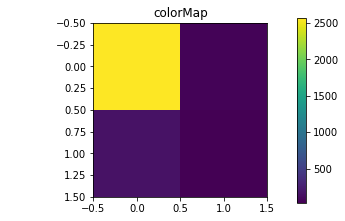

(0.35106382978723405, 0.1746031746031746, 0.23321554770318023, None)
(0.6468554443053818, 0.5756825396825397, 0.5963084286691767, None)
acc 0.9228855721393034
[[2564   61]
 [ 156   33]]


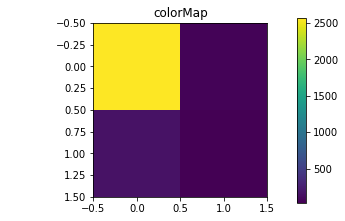

,f1-score,precision,recall,support
0,0.96,0.94,0.98,2625.0
1,0.23,0.35,0.17,189.0
avg / total,0.91,0.90,0.92,2814.0


In [29]:
predicted_labels=train_unl_s(0.001/len(train_L_S),5,tf.truncated_normal_initializer(1,0.1,12))
Results = predictAndPrint(predicted_labels)
Results.to_csv("results.csv")
Results

In [31]:
## normalized training with smooth lf normalizer

def train_nl_s(lr,ep,th):
    
    BATCH_SIZE = 1
    tf.reset_default_graph()


    seed = 12
    with tf.Graph().as_default():

        train_dataset = tf.data.Dataset.from_tensor_slices(train_L_S).batch(BATCH_SIZE)
        dev_dataset = tf.data.Dataset.from_tensor_slices(test_L_S).batch(len(test_L_S))

     
        iterator = tf.data.Iterator.from_structure(train_dataset.output_types,
                                               train_dataset.output_shapes)
        next_element = iterator.get_next()

        train_init_op = iterator.make_initializer(train_dataset)
        dev_init_op = iterator.make_initializer(dev_dataset)

        next_element = iterator.get_next()
        print("next_element",next_element)

        alphas = tf.get_variable('alphas', [NoOfLFs],\
                                 initializer=tf.truncated_normal_initializer(0.1,0.1,seed),\
                                 dtype=tf.float64)

    #     thetas = tf.get_variable('thetas', [1,NoOfLFs],\
    #                              initializer=tf.truncated_normal_initializer(1,0.1,seed),\
    #                              dtype=tf.float64)

        thetas = tf.get_variable('thetas',[1,NoOfLFs],\
                                initializer=th,\
                        dtype=tf.float64)

        print("thetas",thetas)
        k = tf.convert_to_tensor(LF_l, dtype=tf.float64)
        print("k",k)
        print(alphas.graph)
        print(thetas.graph)
        l,s =  tf.unstack(next_element,axis=1)
        print(alphas)
        print(s)
        print("l",l)
        print(s.graph)

        s_ = tf.map_fn(lambda x : tf.maximum(tf.subtract(x,alphas), 0), s,name = "s_")
        print("s_",s_)

       
    
        def iskequalsy(v,s):
            out = tf.where(tf.equal(v,s),tf.ones_like(v),\
                           -tf.ones_like(v))
            print("out",out)
            return out

#         ls_ = tf.multiply(l,s_)

#         nls_ = tf.multiply(l,s_)*-1

        pout = tf.map_fn(lambda c: iskequalsy(l,c)*s_ ,np.array([-1,1],dtype=np.float64),name="pout")
       
#         print("nls",nls_)


    #     lst = tf.matmul(ls_,thetas)
    #     print("lst",lst)
        t_pout = tf.map_fn(lambda x: tf.matmul(x,thetas,transpose_b=True),pout,name="t_pout")
        print("pout",pout)

        print("t_pout",t_pout)

        t =  tf.squeeze(thetas)
        print("t",t)
        
        def ints(y):
            ky = iskequalsy(k,y)
            print("ky",ky)
            out1 = alphas+((tf.exp((t*ky*(1-alphas)))-1)/(t*ky))
            print("intsy",out1)
            return out1
        
#         zy = tf.map_fn(lambda y: tf.reduce_prod(1+tf.exp(t*iskequalsy(k,y)),axis=0),np.arange(NoOfClasses,dtype=np.float64))

        zy = tf.map_fn(lambda y: tf.reduce_prod(1+ints(y),axis=0),\
                   np.array([-1,1],dtype=np.float64),name="zy")
    
        print("zy",zy)
#         zy = tf.map_fn(lambda y: tf.reduce_prod(1+ints(y),axis=0),\
#                        np.array(NoOfClasses,dtype=np.float64))
        
        logz = tf.log(tf.reduce_sum(zy,axis=0),name="logz")
        
        print("logz",logz)
        tf.summary.scalar('logz', logz)
        lsp = tf.reduce_logsumexp(t_pout,axis=0)
        print("lsp",lsp)
        tf.summary.scalar('lsp', tf.reduce_sum(lsp))

    #     normloss = tf.negative(tf.reduce_sum(tf.reduce_logsumexp(t_pout,axis=0)) - logz)  # add z

        normloss = tf.negative(tf.reduce_sum(lsp  - logz  ))


        tf.summary.scalar('un-normloss', normloss)
#         tf.summary.histogram('thetas', t)
#         tf.summary.histogram('alphas', alphas)
        print("normloss",normloss)
        marginals = tf.nn.softmax(t_pout,axis=0)

        print("marginals",marginals)
        predict = tf.argmax(marginals,axis=0)
        print("predict",predict)

    #     pre = tf.metrics.precision(labels,predict)
    #     rec = tf.metrics.recall(labels,predict)
    #     print("loss",loss)
    #     print("nls_",nls_)

    #     global_step = tf.Variable(0, trainable=False,dtype=tf.float64)
    #     starter_learning_rate = 1.0
    #     learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
    #                                            10, 0.96, staircase=True)
    #     train_step = tf.train.AdamOptimizer(learning_rate).minimize(normloss, global_step=global_step) 


    #     train_step = tf.train.AdamOptimizer(0.001).minimize(normloss)
    #     reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    #     reg_constant = 5.0  # Choose an appropriate one.
    #     totalloss = normloss + reg_constant * sum(reg_losses)
        train_step = tf.train.AdamOptimizer(lr).minimize(normloss) 
    #     train_step = tf.train.AdagradOptimizer(0.01).minimize(normloss) 
    #     train_step = tf.train.MomentumOptimizer(0.01,0.2).minimize(normloss) 

    #     train_step = tf.train.GradientDescentOptimizer(0.1).minimize(normloss)

        summary_merged = tf.summary.merge_all()
        train_writer = tf.summary.FileWriter('./summary/train',
                                      tf.get_default_graph())
        test_writer = tf.summary.FileWriter('./summary/test')

        init_g = tf.global_variables_initializer()
        init_l = tf.local_variables_initializer()
        with tf.Session() as sess:
            sess.run(init_g)
            sess.run(init_l)

            # Initialize an iterator over the training dataset.
            for en in range(ep):
                sess.run(train_init_op)
                tl = 0
                try:
                    it = 0
                    while True:
                        sm,_,ls,t = sess.run([summary_merged,train_step,normloss,thetas])
#                         print(t)
#                         print(tl)
                        train_writer.add_summary(sm, it)
#                         if(ls<1e-5):
#                             break
                        tl = tl + ls
                        it = it + 1
                        
                except tf.errors.OutOfRangeError:
                    pass
                print(en,"loss",tl)

                sess.run(dev_init_op)
                sm,a,t,m,pl = sess.run([summary_merged,alphas,thetas,marginals,predict])
                test_writer.add_summary(sm, en)
#                 print(a)
#                 print(t)

#                 unique, counts = np.unique(pl, return_counts=True)
#                 print(dict(zip(unique, counts)))
                print("acc",accuracy_score(true_labels,pl))
                print(precision_recall_fscore_support(np.array(true_labels),np.array(pl),average="binary"))
                print()

            # Initialize an iterator over the validation dataset.
            sess.run(dev_init_op)
            a,t,m,pl = sess.run([alphas,thetas,marginals,predict])
            print(a)
            print(t)

            unique, counts = np.unique(pl, return_counts=True)
            print(dict(zip(unique, counts)))

            print("acc",accuracy_score(true_labels,pl))

            predictAndPrint(pl)
            print(precision_recall_fscore_support(np.array(true_labels),np.array(pl),average="binary"))

            print(precision_recall_fscore_support(np.array(true_labels),np.array(pl),average="macro"))
#             cf = confusion_matrix(true_labels,pl)
#             print(cf)
    return pl

next_element Tensor("IteratorGetNext_1:0", shape=(?, 2, 10), dtype=float64)
thetas <tf.Variable 'thetas:0' shape=(1, 10) dtype=float64_ref>
k Tensor("Const:0", shape=(10,), dtype=float64)
<tf.Variable 'alphas:0' shape=(10,) dtype=float64_ref>
Tensor("unstack:1", shape=(?, 10), dtype=float64)
l Tensor("unstack:0", shape=(?, 10), dtype=float64)
s_ Tensor("s_/TensorArrayStack/TensorArrayGatherV3:0", shape=(?, 10), dtype=float64)
out Tensor("pout/while/Select:0", shape=(?, 10), dtype=float64)
pout Tensor("pout/TensorArrayStack/TensorArrayGatherV3:0", shape=(2, ?, 10), dtype=float64)
t_pout Tensor("t_pout/TensorArrayStack/TensorArrayGatherV3:0", shape=(2, ?, 1), dtype=float64)
t Tensor("Squeeze:0", shape=(10,), dtype=float64)
out Tensor("zy/while/Select:0", shape=(10,), dtype=float64)
ky Tensor("zy/while/Select:0", shape=(10,), dtype=float64)
intsy Tensor("zy/while/add:0", shape=(10,), dtype=float64)
zy Tensor("zy/TensorArrayStack/TensorArrayGatherV3:0", shape=(2,), dtype=float64)
logz Tens

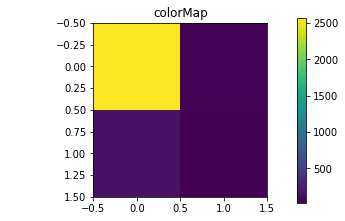

(0.34408602150537637, 0.1693121693121693, 0.22695035460992907, None)
(0.6431933231378407, 0.573037037037037, 0.593086101360333, None)
acc 0.9225302061122956
[[2564   61]
 [ 157   32]]


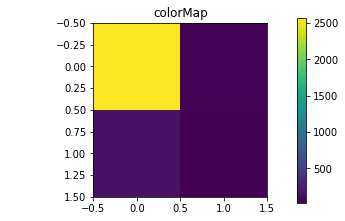

,f1-score,precision,recall,support
0,0.96,0.94,0.98,2625.0
1,0.23,0.34,0.17,189.0
avg / total,0.91,0.90,0.92,2814.0


In [32]:
predicted_labels=train_nl_s(0.001/len(train_L_S),5,tf.truncated_normal_initializer(1,0.1,12))
Results = predictAndPrint(predicted_labels)
Results.to_csv("results.csv")
Results

next_element Tensor("IteratorGetNext_1:0", shape=(?, 2, 10), dtype=float64)
k Tensor("Const_1:0", shape=(10,), dtype=float64)
<tf.Variable 'alphas:0' shape=(10,) dtype=float64_ref>
Tensor("unstack:1", shape=(?, 10), dtype=float64)
l Tensor("unstack:0", shape=(?, 10), dtype=float64)
nls Tensor("mul:0", shape=(?, 10), dtype=float64)
thetas <tf.Variable 'thetas:0' shape=(1, 10) dtype=float64_ref>
pout Tensor("map_1/TensorArrayStack/TensorArrayGatherV3:0", shape=(2, ?, 10), dtype=float64)
t_pout Tensor("map_2/TensorArrayStack/TensorArrayGatherV3:0", shape=(2, ?, 1), dtype=float64)
t_k Tensor("mul_1:0", shape=(10,), dtype=float64)
ints <function ints at 0x7f6cb38b0b70>
zy Tensor("map_3/TensorArrayStack/TensorArrayGatherV3:0", shape=(2,), dtype=float64)
logz Tensor("Log:0", shape=(), dtype=float64)
lsp Tensor("ReduceLogSumExp/add:0", shape=(), dtype=float64)
normloss Tensor("Neg:0", shape=(), dtype=float64)
marginals Tensor("transpose_1:0", shape=(2, ?, 1), dtype=float64)
predict Tensor("Arg

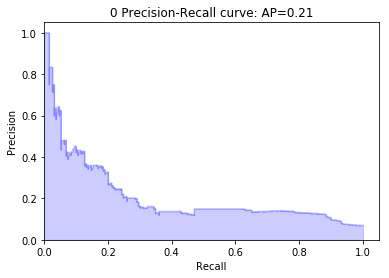

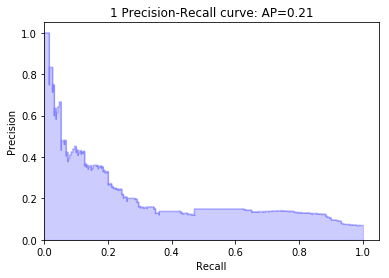

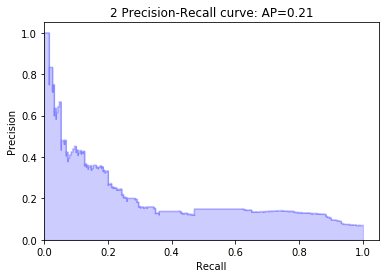

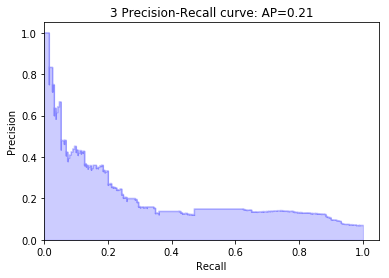

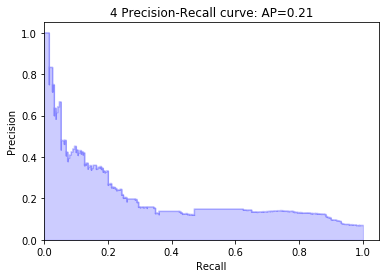

In [147]:
## smooth LFs
BATCH_SIZE = 1
tf.reset_default_graph()

seed = 12
with tf.Graph().as_default():
    
    train_dataset = tf.data.Dataset.from_tensor_slices(train_L_S).batch(BATCH_SIZE)
    dev_dataset = tf.data.Dataset.from_tensor_slices(dev_L_S).batch(dev_L_S.shape[0])

    labels = tf.convert_to_tensor(gold_labels_dev)
    iterator = tf.data.Iterator.from_structure(train_dataset.output_types,
                                           train_dataset.output_shapes)
    next_element = iterator.get_next()

    train_init_op = iterator.make_initializer(train_dataset)
    dev_init_op = iterator.make_initializer(dev_dataset)
   
    next_element = iterator.get_next()
    print("next_element",next_element)

    alphas = tf.get_variable('alphas', [NoOfLFs],\
                             initializer=tf.truncated_normal_initializer(0.1,0.1,seed),\
                             dtype=tf.float64)

    thetas = tf.get_variable('thetas', [1,NoOfLFs],\
                             initializer=tf.truncated_normal_initializer(1,0.1,seed),\
                             dtype=tf.float64)
    
    k = tf.convert_to_tensor(LF_l, dtype=tf.float64)
    print("k",k)
    print(alphas.graph)
    print(thetas.graph)
    l,s =  tf.unstack(next_element,axis=1)
    print(alphas)
    print(s)
    print("l",l)
    print(s.graph)

    s_ = tf.map_fn(lambda x : tf.maximum(tf.subtract(x,alphas), 0), s)

            
        
    ls_ = tf.multiply(l,s_)

    nls_ = tf.multiply(l,s_)*-1
    
    pout = tf.map_fn(lambda x: ls_*x,np.array([-1,1],dtype=np.float64))
    print("nls",nls_)
    print("thetas",thetas)
    
#     lst = tf.matmul(ls_,thetas)
#     print("lst",lst)
    t_pout = tf.map_fn(lambda x: tf.matmul(x,thetas,transpose_b=True),pout)
    print("pout",pout)
    
    print("t_pout",t_pout)

    t = tf.squeeze(thetas)
    t_k =  k*t
    
    print("t_k",t_k)
    
    def ints(y):
        return alphas+((tf.exp((t_k*y)*(1-alphas))-1)/(t_k*y))
    
    print("ints",ints)
    
#     zy = tf.map_fn(lambda y: tf.reduce_prod(1+tf.exp(t_k*y),axis=0),np.array([-1,1],dtype=np.float64))
    
    zy = tf.map_fn(lambda y: tf.reduce_prod(1+ints(y),axis=0),\
                   np.array([-1,1],dtype=np.float64))

    
    logz = tf.log(tf.reduce_sum(zy,axis=0))
    print("zy",zy)
    print("logz",logz)
    
    lsp = tf.reduce_logsumexp(t_pout)
    print("lsp",lsp)

#     normloss = tf.negative(tf.reduce_sum(tf.reduce_logsumexp(t_pout,axis=0)) - logz)  # add z

    normloss = tf.negative(tf.reduce_sum(tf.reduce_logsumexp(t_pout,axis=0) - logz))


    print("normloss",normloss)
    marginals = tf.nn.softmax(t_pout,axis=0)
      
    print("marginals",marginals)
    predict = tf.argmax(marginals,axis=0)
    print("predict",predict)
    
#     pre = tf.metrics.precision(labels,predict)
#     rec = tf.metrics.recall(labels,predict)
#     print("loss",loss)
#     print("nls_",nls_)

#     global_step = tf.Variable(0, trainable=False,dtype=tf.float64)
#     starter_learning_rate = 1.0
#     learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
#                                            10, 0.96, staircase=True)
#     train_step = tf.train.AdamOptimizer(learning_rate).minimize(normloss, global_step=global_step) 


#     train_step = tf.train.AdamOptimizer(0.001).minimize(normloss)
#     reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
#     reg_constant = 5.0  # Choose an appropriate one.
#     totalloss = normloss + reg_constant * sum(reg_losses)
    train_step = tf.train.MomentumOptimizer(0.0000001,0.002).minimize(normloss) 
#     train_step = tf.train.AdagradOptimizer(0.01).minimize(normloss) 
#     train_step = tf.train.MomentumOptimizer(0.01,0.2).minimize(normloss) 

#     train_step = tf.train.GradientDescentOptimizer(0.1).minimize(normloss)

    init_g = tf.global_variables_initializer()
    init_l = tf.local_variables_initializer()
    with tf.Session() as sess:
        sess.run(init_g)
        sess.run(init_l)
        
        # Initialize an iterator over the training dataset.
        for it in range(5):
            sess.run(train_init_op)
            tl = 0
            try:
                while True:
                    _,ls = sess.run([train_step,normloss])
                    tl = tl + ls
            except tf.errors.OutOfRangeError:
                pass
            print(it,"loss",tl)
            
            sess.run(dev_init_op)
            a,t,m,pl = sess.run([alphas,thetas,marginals,predict])
            print(a)
            print(t)
           
          
                      
#         MentionScorer(dev_cands, L_gold_dev).score(m[1::].flatten())
            

            unique, counts = np.unique(pl, return_counts=True)
            print(dict(zip(unique, counts)))
            print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl),average="binary"))
            drawPRcurve(np.array(gold_labels_dev),np.array(m[1::].flatten()),it)
            print()
            
        # Initialize an iterator over the validation dataset.
        sess.run(dev_init_op)
        a,t,m,pl = sess.run([alphas,thetas,marginals,predict])
        print(a)
        print(t)
                      
        MentionScorer(dev_cands, L_gold_dev).score(m[1::].flatten())
    
       
        unique, counts = np.unique(pl, return_counts=True)
        print(dict(zip(unique, counts)))
       
        print("acc",accuracy_score(gold_labels_dev,pl))
  
        print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl)))
        print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl),average="macro"))
        cf = confusion_matrix(gold_labels_dev,pl)
        print(cf)
        print("prec: tp/(tp+fp)",cf[1][1]/(cf[1][1]+cf[0][1]),"recall: tp/(tp+fn)",cf[1][1]/(cf[1][1]+cf[1][0]))
        print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl),average="binary"))

    
      
            


next_element Tensor("IteratorGetNext_1:0", shape=(?, 2, 10), dtype=float64)
k Tensor("Const_1:0", shape=(10,), dtype=float64)
<tf.Variable 'alphas:0' shape=(10,) dtype=float64_ref>
Tensor("unstack:1", shape=(?, 10), dtype=float64)
l Tensor("unstack:0", shape=(?, 10), dtype=float64)
nls Tensor("mul:0", shape=(?, 10), dtype=float64)
thetas <tf.Variable 'thetas:0' shape=(1, 10) dtype=float64_ref>
pout Tensor("map_1/TensorArrayStack/TensorArrayGatherV3:0", shape=(2, ?, 10), dtype=float64)
t_pout Tensor("map_2/TensorArrayStack/TensorArrayGatherV3:0", shape=(2, ?, 1), dtype=float64)
t_k Tensor("mul_1:0", shape=(10,), dtype=float64)
ints <function ints at 0x7f6c7dd8dae8>
zy Tensor("map_3/TensorArrayStack/TensorArrayGatherV3:0", shape=(2,), dtype=float64)
logz Tensor("Log:0", shape=(), dtype=float64)
lsp Tensor("ReduceLogSumExp/add:0", shape=(), dtype=float64)
normloss Tensor("Neg:0", shape=(), dtype=float64)
marginals Tensor("transpose_1:0", shape=(2, ?, 1), dtype=float64)
predict Tensor("Arg

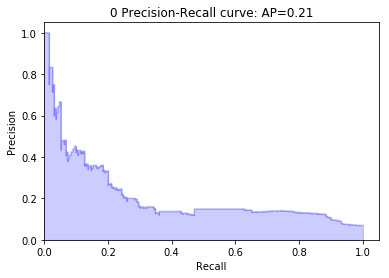

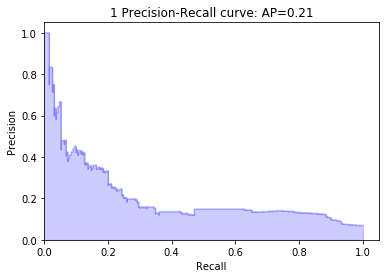

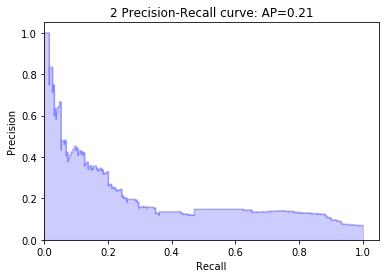

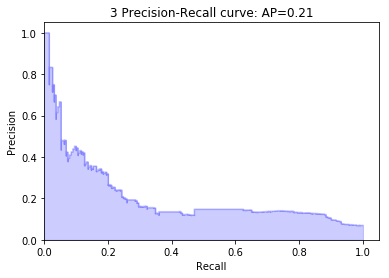

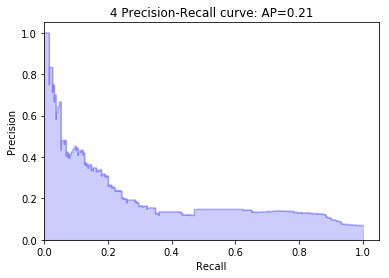

In [149]:
## smooth LFs #other configs
BATCH_SIZE = 1
tf.reset_default_graph()

seed = 12
with tf.Graph().as_default():
    
    train_dataset = tf.data.Dataset.from_tensor_slices(train_L_S).batch(BATCH_SIZE)
    dev_dataset = tf.data.Dataset.from_tensor_slices(dev_L_S).batch(dev_L_S.shape[0])

    labels = tf.convert_to_tensor(gold_labels_dev)
    iterator = tf.data.Iterator.from_structure(train_dataset.output_types,
                                           train_dataset.output_shapes)
    next_element = iterator.get_next()

    train_init_op = iterator.make_initializer(train_dataset)
    dev_init_op = iterator.make_initializer(dev_dataset)
   
    next_element = iterator.get_next()
    print("next_element",next_element)

    alphas = tf.get_variable('alphas', [NoOfLFs],\
                             initializer=tf.truncated_normal_initializer(0.2,0.1,seed),\
                             dtype=tf.float64)

    thetas = tf.get_variable('thetas', [1,NoOfLFs],\
                             initializer=tf.truncated_normal_initializer(1,0.1,seed),\
                             dtype=tf.float64)
    
    k = tf.convert_to_tensor(LF_l, dtype=tf.float64)
    print("k",k)
    print(alphas.graph)
    print(thetas.graph)
    l,s =  tf.unstack(next_element,axis=1)
    print(alphas)
    print(s)
    print("l",l)
    print(s.graph)

    s_ = tf.map_fn(lambda x : tf.maximum(tf.subtract(x,alphas), 0), s)

            
        
    ls_ = tf.multiply(l,s_)

    nls_ = tf.multiply(l,s_)*-1
    
    pout = tf.map_fn(lambda x: ls_*x,np.array([-1,1],dtype=np.float64))
    print("nls",nls_)
    print("thetas",thetas)
    
#     lst = tf.matmul(ls_,thetas)
#     print("lst",lst)
    t_pout = tf.map_fn(lambda x: tf.matmul(x,thetas,transpose_b=True),pout)
    print("pout",pout)
    
    print("t_pout",t_pout)

    t_k =  k*tf.squeeze(thetas)
    print("t_k",t_k)
    
    def ints(y):
        return alphas+((tf.exp((t_k*y)*(1-alphas))-1)/(t_k*y))
    
    print("ints",ints)
    
#     zy = tf.map_fn(lambda y: tf.reduce_prod(1+tf.exp(t_k*y),axis=0),np.array([-1,1],dtype=np.float64))
    
    zy = tf.map_fn(lambda y: tf.reduce_prod(1+ints(y),axis=0),\
                   np.array([-1,1],dtype=np.float64))

    
    logz = tf.log(tf.reduce_sum(zy,axis=0))
    print("zy",zy)
    print("logz",logz)
    
    lsp = tf.reduce_logsumexp(t_pout)
    print("lsp",lsp)

#     normloss = tf.negative(tf.reduce_sum(tf.reduce_logsumexp(t_pout,axis=0)) - logz)  # add z

    normloss = tf.negative(tf.reduce_sum(tf.reduce_logsumexp(t_pout,axis=0) - logz))


    print("normloss",normloss)
    marginals = tf.nn.softmax(t_pout,axis=0)
      
    print("marginals",marginals)
    predict = tf.argmax(marginals,axis=0)
    print("predict",predict)
    
#     pre = tf.metrics.precision(labels,predict)
#     rec = tf.metrics.recall(labels,predict)
#     print("loss",loss)
#     print("nls_",nls_)

#     global_step = tf.Variable(0, trainable=False,dtype=tf.float64)
#     starter_learning_rate = 1.0
#     learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
#                                            10, 0.96, staircase=True)
#     train_step = tf.train.AdamOptimizer(learning_rate).minimize(normloss, global_step=global_step) 


    train_step = tf.train.AdamOptimizer(0.0000001).minimize(normloss)
#     reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
#     reg_constant = 5.0  # Choose an appropriate one.
#     totalloss = normloss + reg_constant * sum(reg_losses)
#     train_step = tf.train.MomentumOptimizer(0.0000001,0.002).minimize(normloss) 
#     train_step = tf.train.AdagradOptimizer(0.01).minimize(normloss) 
#     train_step = tf.train.MomentumOptimizer(0.01,0.2).minimize(normloss) 

#     train_step = tf.train.GradientDescentOptimizer(0.1).minimize(normloss)

    init_g = tf.global_variables_initializer()
    init_l = tf.local_variables_initializer()
    with tf.Session() as sess:
        sess.run(init_g)
        sess.run(init_l)
        
        # Initialize an iterator over the training dataset.
        for it in range(5):
            sess.run(train_init_op)
            tl = 0
            try:
                while True:
                    _,ls = sess.run([train_step,normloss])
                    tl = tl + ls
            except tf.errors.OutOfRangeError:
                pass
            print(it,"loss",tl)
            
            sess.run(dev_init_op)
            a,t,m,pl = sess.run([alphas,thetas,marginals,predict])
            print(a)
            print(t)
           
          
                      
#         MentionScorer(dev_cands, L_gold_dev).score(m[1::].flatten())
            

            unique, counts = np.unique(pl, return_counts=True)
            print(dict(zip(unique, counts)))
            print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl),average="binary"))
            drawPRcurve(np.array(gold_labels_dev),np.array(m[1::].flatten()),it)
            print()
            
        # Initialize an iterator over the validation dataset.
        sess.run(dev_init_op)
        a,t,m,pl = sess.run([alphas,thetas,marginals,predict])
        print(a)
        print(t)
                      
        MentionScorer(dev_cands, L_gold_dev).score(m[1::].flatten())
    
       
        unique, counts = np.unique(pl, return_counts=True)
        print(dict(zip(unique, counts)))
       
        print("acc",accuracy_score(gold_labels_dev,pl))
  
        print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl)))
        print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl),average="macro"))
        cf = confusion_matrix(gold_labels_dev,pl)
        print(cf)
        print("prec: tp/(tp+fp)",cf[1][1]/(cf[1][1]+cf[0][1]),"recall: tp/(tp+fn)",cf[1][1]/(cf[1][1]+cf[1][0]))
        print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl),average="binary"))

    
      
            


In [51]:

## varying z weight 

def train(z_weight):
    BATCH_SIZE = 1
    tf.reset_default_graph()

    seed = 12
    with tf.Graph().as_default():

        train_dataset = tf.data.Dataset.from_tensor_slices(train_L_S).batch(BATCH_SIZE)
        dev_dataset = tf.data.Dataset.from_tensor_slices(dev_L_S).batch(dev_L_S.shape[0])

        labels = tf.convert_to_tensor(gold_labels_dev)
        iterator = tf.data.Iterator.from_structure(train_dataset.output_types,
                                               train_dataset.output_shapes)
        next_element = iterator.get_next()

        train_init_op = iterator.make_initializer(train_dataset)
        dev_init_op = iterator.make_initializer(dev_dataset)
        
        zw = tf.convert_to_tensor(z_weight,dtype=tf.float64)

        next_element = iterator.get_next()
#         print("next_element",next_element)

        alphas = tf.get_variable('alphas', [NoOfLFs],\
                                 initializer=tf.truncated_normal_initializer(0.2,0.1,seed),\
                                 dtype=tf.float64)
        thetas = tf.get_variable('thetas', [1,NoOfLFs],\
                                 initializer=tf.truncated_normal_initializer(1,0.1,seed),\
                                 dtype=tf.float64)

        k = tf.convert_to_tensor(LF_l, dtype=tf.float64)
#         print("k",k)
#         print(alphas.graph)
#         print(thetas.graph)
        l,s =  tf.unstack(next_element,axis=1)
#         print(alphas)
#         print(s)
#         print("l",l)
#         print(s.graph)

        s_ = tf.map_fn(lambda x : tf.maximum(tf.subtract(x,alphas), 0), s)



        ls_ = tf.multiply(l,s_)

        nls_ = tf.multiply(l,s_)*-1

        pout = tf.map_fn(lambda x: l*x,np.array([-1,1],dtype=np.float64))
#         print("nls",nls_)
#         print("thetas",thetas)

    #     lst = tf.matmul(ls_,thetas)
    #     print("lst",lst)
        t_pout = tf.map_fn(lambda x: tf.matmul(x,thetas,transpose_b=True),pout)
#         print("pout",pout)

#         print("t_pout",t_pout)

        t_k =  k*tf.squeeze(thetas)
#         print("t_k",t_k)

        zy = tf.map_fn(lambda y: tf.reduce_prod(1+tf.exp(t_k*y),axis=0),np.array([-1,1],dtype=np.float64))

        logz = tf.log(tf.reduce_sum(zy,axis=0))
#         print("zy",zy)
#         print("logz",logz)

        lsp = tf.reduce_logsumexp(t_pout)
#         print("lsp",lsp)

    #     normloss = tf.negative(tf.reduce_sum(tf.reduce_logsumexp(t_pout,axis=0)) - logz)  # add z

        normloss = tf.negative(tf.reduce_sum(tf.reduce_logsumexp(t_pout,axis=0) - zw*logz))


#         print("normloss",normloss)
        marginals = tf.nn.softmax(t_pout,axis=0)

#         print("marginals",marginals)
        predict = tf.argmax(marginals,axis=0)
#         print("predict",predict)

    #     pre = tf.metrics.precision(labels,predict)
    #     rec = tf.metrics.recall(labels,predict)
    #     print("loss",loss)
    #     print("nls_",nls_)

    #     global_step = tf.Variable(0, trainable=False,dtype=tf.float64)
    #     starter_learning_rate = 1.0
    #     learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
    #                                            10, 0.96, staircase=True)
    #     train_step = tf.train.AdamOptimizer(learning_rate).minimize(normloss, global_step=global_step) 


    #     train_step = tf.train.AdamOptimizer(0.001).minimize(normloss)
    #     reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    #     reg_constant = 5.0  # Choose an appropriate one.
    #     totalloss = normloss + reg_constant * sum(reg_losses)
        train_step = tf.train.AdamOptimizer(0.01).minimize(normloss) 
    #     train_step = tf.train.AdagradOptimizer(0.01).minimize(normloss) 
    #     train_step = tf.train.MomentumOptimizer(0.01,0.2).minimize(normloss) 

    #     train_step = tf.train.GradientDescentOptimizer(0.1).minimize(normloss)

        init_g = tf.global_variables_initializer()
        init_l = tf.local_variables_initializer()
        with tf.Session() as sess:
            sess.run(init_g)
            sess.run(init_l)

            # Initialize an iterator over the training dataset.
            for it in range(1):
                sess.run(train_init_op)
                tl = 0
                try:
                    while True:
                        _,ls = sess.run([train_step,normloss])
                        tl = tl + ls
                except tf.errors.OutOfRangeError:
                    pass
                print(it,"loss",tl)

#                 sess.run(dev_init_op)
#                 a,t,m,pl = sess.run([alphas,thetas,marginals,predict])
#                 print(a)
#                 print(t)


    #         MentionScorer(dev_cands, L_gold_dev).score(m[1::].flatten())


#                 unique, counts = np.unique(pl, return_counts=True)
#                 print(dict(zip(unique, counts)))
#                 print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl),average="binary"))
#                 print()

            # Initialize an iterator over the validation dataset.
            sess.run(dev_init_op)
            a,t,m,pl = sess.run([alphas,thetas,marginals,predict])
            print(a)
            print(t)

            MentionScorer(dev_cands, L_gold_dev).score(m[1::].flatten())


            unique, counts = np.unique(pl, return_counts=True)
            print(dict(zip(unique, counts)))

            print("acc",accuracy_score(gold_labels_dev,pl))

            print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl)))
            print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl),average="macro"))
            cf = confusion_matrix(gold_labels_dev,pl)
            print(cf)
            print("prec: tp/(tp+fp)",cf[1][1]/(cf[1][1]+cf[0][1]),"recall: tp/(tp+fn)",cf[1][1]/(cf[1][1]+cf[1][0]))
            print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl),average="binary"))

    
      

for w in np.linspace(0,1,10):
    print()
    print("z-weight:",w)
    train(w)

z-weight: 0.0
0 loss -1389905.435892547
[0.31754463 0.01421453 0.20955965 0.20062431 0.30637787 0.24133855
 0.369206   0.23120785 0.34633471 0.2647233 ]
[[ 1.55314453e+00 -8.50306967e+00  6.63025697e+01  5.69882534e+01
  -1.21856102e+01  1.73452451e+02  1.10987785e-01  6.05973130e+01
   5.55920061e+01  1.63989427e+01]]
Scores (Un-adjusted)
Pos. class accuracy: 0.534
Neg. class accuracy: 0.927
Precision            0.345
Recall               0.534
F1                   0.419
----------------------------------------
TP: 101 | FP: 192 | TN: 2433 | FN: 88

{0: 2521, 1: 293}
acc 0.900497512437811
(array([0.96509322, 0.3447099 ]), array([0.92685714, 0.53439153]), array([0.94558881, 0.41908714]), array([2625,  189]))
(0.6549015572941557, 0.7306243386243386, 0.6823379718848624, None)
[[2433  192]
 [  88  101]]
prec: tp/(tp+fp) 0.3447098976109215 recall: tp/(tp+fn) 0.5343915343915344
(0.3447098976109215, 0.5343915343915344, 0.4190871369294606, None)
z-weight: 0.1111111111111111
0 loss -1000437.19

0 loss 118270.01096733002
[0.31754463 0.01421453 0.20955965 0.20062431 0.30637787 0.24133855
 0.369206   0.23120785 0.34633471 0.2647233 ]
[[ 0.6833814   0.67489471  1.16327265  1.08791289  0.63841563  7.31378212
   0.68492701 -0.4667125  -0.56059337 -0.66732256]]
Scores (Un-adjusted)
Pos. class accuracy: 0.577
Neg. class accuracy: 0.871
Precision            0.244
Recall               0.577
F1                   0.343
----------------------------------------
TP: 109 | FP: 338 | TN: 2287 | FN: 80

{0: 2367, 1: 447}
acc 0.851457000710732
(array([0.96620194, 0.24384787]), array([0.8712381 , 0.57671958]), array([0.91626603, 0.3427673 ]), array([2625,  189]))
(0.6050249090543065, 0.7239788359788359, 0.6295166606192549, None)
[[2287  338]
 [  80  109]]
prec: tp/(tp+fp) 0.24384787472035793 recall: tp/(tp+fn) 0.5767195767195767
(0.24384787472035793, 0.5767195767195767, 0.34276729559748426, None)
z-weight: 1.0
0 loss 144103.45632156145
[0.31754463 0.01421453 0.20955965 0.20062431 0.30637787 0.24

In [80]:
# set learning rate 0.1/len(train_L_S)  --marked

def train():
    BATCH_SIZE = 1
    tf.reset_default_graph()

    seed = 12
    with tf.Graph().as_default():

        train_dataset = tf.data.Dataset.from_tensor_slices(train_L_S).batch(BATCH_SIZE)
        dev_dataset = tf.data.Dataset.from_tensor_slices(dev_L_S).batch(dev_L_S.shape[0])

        labels = tf.convert_to_tensor(gold_labels_dev)
        iterator = tf.data.Iterator.from_structure(train_dataset.output_types,
                                               train_dataset.output_shapes)
        next_element = iterator.get_next()

        train_init_op = iterator.make_initializer(train_dataset)
        dev_init_op = iterator.make_initializer(dev_dataset)

        next_element = iterator.get_next()
#         print("next_element",next_element)

        alphas = tf.get_variable('alphas', [NoOfLFs],\
                                 initializer=tf.truncated_normal_initializer(0.2,0.1,seed),\
                                 dtype=tf.float64)
        thetas = tf.get_variable('thetas', [1,NoOfLFs],\
                                 initializer=tf.truncated_normal_initializer(1,0.1,seed),\
                                 dtype=tf.float64)


        k = tf.convert_to_tensor(LF_l, dtype=tf.float64)
#         print("k",k)
#         print(alphas.graph)
#         print(thetas.graph)
        l,s =  tf.unstack(next_element,axis=1)
#         print(alphas)
#         print(s)
#         print("l",l)
#         print(s.graph)

        s_ = tf.map_fn(lambda x : tf.maximum(tf.subtract(x,alphas), 0), s)



        ls_ = tf.multiply(l,s_)

        nls_ = tf.multiply(l,s_)*-1

        pout = tf.map_fn(lambda x: l*x,np.array([-1,1],dtype=np.float64))
#         print("nls",nls_)
#         print("thetas",thetas)

    #     lst = tf.matmul(ls_,thetas)
    #     print("lst",lst)
        t_pout = tf.map_fn(lambda x: tf.matmul(x,thetas,transpose_b=True),pout)
#         print("pout",pout)

#         print("t_pout",t_pout)

        t_k =  k*tf.squeeze(thetas)
#         print("t_k",t_k)

        zy = tf.map_fn(lambda y: tf.reduce_prod(1+tf.exp(t_k*y),axis=0),np.array([-1,1],dtype=np.float64))

        logz = tf.log(tf.reduce_sum(zy,axis=0))
#         print("zy",zy)
#         print("logz",logz)

        lsp = tf.reduce_logsumexp(t_pout)
#         print("lsp",lsp)

    #     normloss = tf.negative(tf.reduce_sum(tf.reduce_logsumexp(t_pout,axis=0)) - logz)  # add z

        normloss = tf.negative(tf.reduce_sum(tf.reduce_logsumexp(t_pout,axis=0) - logz))


#         print("normloss",normloss)
        marginals = tf.nn.softmax(t_pout,axis=0)

#         print("marginals",marginals)
        predict = tf.argmax(marginals,axis=0)
#         print("predict",predict)

    #     pre = tf.metrics.precision(labels,predict)
    #     rec = tf.metrics.recall(labels,predict)
    #     print("loss",loss)
    #     print("nls_",nls_)

      

    #     train_step = tf.train.AdamOptimizer(0.001).minimize(normloss)
#         reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
#         print("reg",reg_losses)

#         totalloss = normloss + tf.reduce_sum(reg_losses)
        
#         global_step = tf.Variable(0, trainable=False,dtype=tf.float64)
#         starter_learning_rate = 0.1/len(train_L_S)
#         learning_rate = tf.train.polynomial_decay(starter_learning_rate, global_step,
#                                                10, 0.95)


#         train_step = tf.train.AdamOptimizer(learning_rate).minimize(totalloss, global_step=global_step) 

        train_step = tf.train.AdamOptimizer(0.1/len(train_L_S)).minimize(normloss) 
    #     train_step = tf.train.AdagradOptimizer(0.01).minimize(normloss) 
    #     train_step = tf.train.MomentumOptimizer(0.01,0.2).minimize(normloss) 

    #     train_step = tf.train.GradientDescentOptimizer(0.1).minimize(normloss)

        init_g = tf.global_variables_initializer()
        init_l = tf.local_variables_initializer()
        with tf.Session() as sess:
            sess.run(init_g)
            sess.run(init_l)

            # Initialize an iterator over the training dataset.
            for it in range(5):
                sess.run(train_init_op)
                tl = 0
                try:
                    while True:
                        _,ls = sess.run([train_step,normloss])
                        tl = tl + ls
                except tf.errors.OutOfRangeError:
                    pass
                print(it,"loss",tl)

                sess.run(dev_init_op)
                a,t,m,pl = sess.run([alphas,thetas,marginals,predict])
#                 print(a)
                print(t)


    #         MentionScorer(dev_cands, L_gold_dev).score(m[1::].flatten())


#                 unique, counts = np.unique(pl, return_counts=True)
#                 print(dict(zip(unique, counts)))
                print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl),average="binary"))
                print()

            # Initialize an iterator over the validation dataset.
            sess.run(dev_init_op)
            a,t,m,pl = sess.run([alphas,thetas,marginals,predict])
#             print(a)
            print(t)

            MentionScorer(dev_cands, L_gold_dev).score(m[1::].flatten())


#             unique, counts = np.unique(pl, return_counts=True)
#             print(dict(zip(unique, counts)))

#             print("acc",accuracy_score(gold_labels_dev,pl))

#             print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl)))
#             print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl),average="macro"))
#             cf = confusion_matrix(gold_labels_dev,pl)
#             print(cf)
#             print("prec: tp/(tp+fp)",cf[1][1]/(cf[1][1]+cf[0][1]),"recall: tp/(tp+fn)",cf[1][1]/(cf[1][1]+cf[1][0]))
            print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl),average="binary"))

train()

0 loss 177328.68299044456
[[1.01874088 0.71637454 0.92309079 0.91201652 1.00877974 1.12112714
  1.07023119 1.08008369 1.18919429 1.12356771]]
(0.3527397260273973, 0.544973544973545, 0.4282744282744283, None)

1 loss 170637.539636164
[[0.92056097 0.61998249 0.84490993 0.83059571 0.91264682 1.19233795
  0.9717674  1.09133108 1.18678918 1.07515922]]
(0.3527397260273973, 0.544973544973545, 0.4282744282744283, None)

2 loss 166039.65982295244
[[0.82307524 0.5266278  0.7815422  0.76270372 0.81926292 1.25204292
  0.87374085 1.06482643 1.14503249 0.9873967 ]]
(0.3527397260273973, 0.544973544973545, 0.4282744282744283, None)

3 loss 162804.3234122617
[[0.72696341 0.44358681 0.73996419 0.71626628 0.73238314 1.29932764
  0.77637412 1.01548014 1.08334649 0.89321343]]
(0.3541666666666667, 0.5396825396825397, 0.4276729559748428, None)

4 loss 160454.5286629692
[[0.63422629 0.39421639 0.71988625 0.69252585 0.65931495 1.33652514
  0.68013933 0.95581433 1.01362187 0.79765871]]
(0.3541666666666667, 0.53

In [153]:
# set learning rate 0.1/len(train_L_S), run 10 iterations

def train():
    BATCH_SIZE = 1
    tf.reset_default_graph()

    seed = 12
    with tf.Graph().as_default():

        train_dataset = tf.data.Dataset.from_tensor_slices(train_L_S).batch(BATCH_SIZE)
        dev_dataset = tf.data.Dataset.from_tensor_slices(dev_L_S).batch(dev_L_S.shape[0])

        labels = tf.convert_to_tensor(gold_labels_dev)
        iterator = tf.data.Iterator.from_structure(train_dataset.output_types,
                                               train_dataset.output_shapes)
        next_element = iterator.get_next()

        train_init_op = iterator.make_initializer(train_dataset)
        dev_init_op = iterator.make_initializer(dev_dataset)

        next_element = iterator.get_next()
#         print("next_element",next_element)

        alphas = tf.get_variable('alphas', [NoOfLFs],\
                                 initializer=tf.truncated_normal_initializer(0.2,0.1,seed),\
                                 dtype=tf.float64)
        thetas = tf.get_variable('thetas', [1,NoOfLFs],\
                                 initializer=tf.truncated_normal_initializer(1,0.1,seed),\
                                 dtype=tf.float64)


        k = tf.convert_to_tensor(LF_l, dtype=tf.float64)
#         print("k",k)
#         print(alphas.graph)
#         print(thetas.graph)
        l,s =  tf.unstack(next_element,axis=1)
#         print(alphas)
#         print(s)
#         print("l",l)
#         print(s.graph)

        s_ = tf.map_fn(lambda x : tf.maximum(tf.subtract(x,alphas), 0), s)



        ls_ = tf.multiply(l,s_)

        nls_ = tf.multiply(l,s_)*-1

        pout = tf.map_fn(lambda x: l*x,np.array([-1,1],dtype=np.float64))
#         print("nls",nls_)
#         print("thetas",thetas)

    #     lst = tf.matmul(ls_,thetas)
    #     print("lst",lst)
        t_pout = tf.map_fn(lambda x: tf.matmul(x,thetas,transpose_b=True),pout)
#         print("pout",pout)

#         print("t_pout",t_pout)

        t_k =  k*tf.squeeze(thetas)
#         print("t_k",t_k)

        zy = tf.map_fn(lambda y: tf.reduce_prod(1+tf.exp(t_k*y),axis=0),np.array([-1,1],dtype=np.float64))

        logz = tf.log(tf.reduce_sum(zy,axis=0))
#         print("zy",zy)
#         print("logz",logz)

        lsp = tf.reduce_logsumexp(t_pout)
#         print("lsp",lsp)

    #     normloss = tf.negative(tf.reduce_sum(tf.reduce_logsumexp(t_pout,axis=0)) - logz)  # add z

        normloss = tf.negative(tf.reduce_sum(tf.reduce_logsumexp(t_pout,axis=0) - logz))


#         print("normloss",normloss)
        marginals = tf.nn.softmax(t_pout,axis=0)

#         print("marginals",marginals)
        predict = tf.argmax(marginals,axis=0)
#         print("predict",predict)

    #     pre = tf.metrics.precision(labels,predict)
    #     rec = tf.metrics.recall(labels,predict)
    #     print("loss",loss)
    #     print("nls_",nls_)

      

    #     train_step = tf.train.AdamOptimizer(0.001).minimize(normloss)
#         reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
#         print("reg",reg_losses)

#         totalloss = normloss + tf.reduce_sum(reg_losses)
        
#         global_step = tf.Variable(0, trainable=False,dtype=tf.float64)
#         starter_learning_rate = 0.1/len(train_L_S)
#         learning_rate = tf.train.polynomial_decay(starter_learning_rate, global_step,
#                                                10, 0.95)


#         train_step = tf.train.AdamOptimizer(learning_rate).minimize(totalloss, global_step=global_step) 

        train_step = tf.train.AdamOptimizer(0.1/len(train_L_S)).minimize(normloss) 
    #     train_step = tf.train.AdagradOptimizer(0.01).minimize(normloss) 
    #     train_step = tf.train.MomentumOptimizer(0.01,0.2).minimize(normloss) 

    #     train_step = tf.train.GradientDescentOptimizer(0.1).minimize(normloss)

        init_g = tf.global_variables_initializer()
        init_l = tf.local_variables_initializer()
        with tf.Session() as sess:
            sess.run(init_g)
            sess.run(init_l)

            # Initialize an iterator over the training dataset.
            for it in range(10):
                sess.run(train_init_op)
                tl = 0
                try:
                    while True:
                        _,ls = sess.run([train_step,normloss])
                        tl = tl + ls
                except tf.errors.OutOfRangeError:
                    pass
                print(it,"loss",tl)

                sess.run(dev_init_op)
                a,t,m,pl = sess.run([alphas,thetas,marginals,predict])
#                 print(a)
                print(t)


    #         MentionScorer(dev_cands, L_gold_dev).score(m[1::].flatten())


#                 unique, counts = np.unique(pl, return_counts=True)
#                 print(dict(zip(unique, counts)))
                print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl),average="binary"))
                print()

            # Initialize an iterator over the validation dataset.
            sess.run(dev_init_op)
            a,t,m,pl = sess.run([alphas,thetas,marginals,predict])
#             print(a)
            print(t)

            MentionScorer(dev_cands, L_gold_dev).score(m[1::].flatten())


#             unique, counts = np.unique(pl, return_counts=True)
#             print(dict(zip(unique, counts)))

#             print("acc",accuracy_score(gold_labels_dev,pl))

#             print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl)))
#             print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl),average="macro"))
#             cf = confusion_matrix(gold_labels_dev,pl)
#             print(cf)
#             print("prec: tp/(tp+fp)",cf[1][1]/(cf[1][1]+cf[0][1]),"recall: tp/(tp+fn)",cf[1][1]/(cf[1][1]+cf[1][0]))
            print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl),average="binary"))

train()

0 loss 177328.68299044456
[[1.01874088 0.71637454 0.92309079 0.91201652 1.00877974 1.12112714
  1.07023119 1.08008369 1.18919429 1.12356771]]
(0.3527397260273973, 0.544973544973545, 0.4282744282744283, None)

1 loss 170637.539636164
[[0.92056097 0.61998249 0.84490993 0.83059571 0.91264682 1.19233795
  0.9717674  1.09133108 1.18678918 1.07515922]]
(0.3527397260273973, 0.544973544973545, 0.4282744282744283, None)

2 loss 166039.65982295244
[[0.82307524 0.5266278  0.7815422  0.76270372 0.81926292 1.25204292
  0.87374085 1.06482643 1.14503249 0.9873967 ]]
(0.3527397260273973, 0.544973544973545, 0.4282744282744283, None)

3 loss 162804.3234122617
[[0.72696341 0.44358681 0.73996419 0.71626628 0.73238314 1.29932764
  0.77637412 1.01548014 1.08334649 0.89321343]]
(0.3541666666666667, 0.5396825396825397, 0.4276729559748428, None)

4 loss 160454.5286629692
[[0.63422629 0.39421639 0.71988625 0.69252585 0.65931495 1.33652514
  0.68013933 0.95581433 1.01362187 0.79765871]]
(0.3541666666666667, 0.53

In [154]:
# set learning rate 0.1/len(train_L_S), run 15 iterations

def train():
    BATCH_SIZE = 1
    tf.reset_default_graph()

    seed = 12
    with tf.Graph().as_default():

        train_dataset = tf.data.Dataset.from_tensor_slices(train_L_S).batch(BATCH_SIZE)
        dev_dataset = tf.data.Dataset.from_tensor_slices(dev_L_S).batch(dev_L_S.shape[0])

        labels = tf.convert_to_tensor(gold_labels_dev)
        iterator = tf.data.Iterator.from_structure(train_dataset.output_types,
                                               train_dataset.output_shapes)
        next_element = iterator.get_next()

        train_init_op = iterator.make_initializer(train_dataset)
        dev_init_op = iterator.make_initializer(dev_dataset)

        next_element = iterator.get_next()
#         print("next_element",next_element)

        alphas = tf.get_variable('alphas', [NoOfLFs],\
                                 initializer=tf.truncated_normal_initializer(0.2,0.1,seed),\
                                 dtype=tf.float64)
        thetas = tf.get_variable('thetas', [1,NoOfLFs],\
                                 initializer=tf.truncated_normal_initializer(1,0.1,seed),\
                                 dtype=tf.float64)


        k = tf.convert_to_tensor(LF_l, dtype=tf.float64)
#         print("k",k)
#         print(alphas.graph)
#         print(thetas.graph)
        l,s =  tf.unstack(next_element,axis=1)
#         print(alphas)
#         print(s)
#         print("l",l)
#         print(s.graph)

        s_ = tf.map_fn(lambda x : tf.maximum(tf.subtract(x,alphas), 0), s)



        ls_ = tf.multiply(l,s_)

        nls_ = tf.multiply(l,s_)*-1

        pout = tf.map_fn(lambda x: l*x,np.array([-1,1],dtype=np.float64))
#         print("nls",nls_)
#         print("thetas",thetas)

    #     lst = tf.matmul(ls_,thetas)
    #     print("lst",lst)
        t_pout = tf.map_fn(lambda x: tf.matmul(x,thetas,transpose_b=True),pout)
#         print("pout",pout)

#         print("t_pout",t_pout)

        t_k =  k*tf.squeeze(thetas)
#         print("t_k",t_k)

        zy = tf.map_fn(lambda y: tf.reduce_prod(1+tf.exp(t_k*y),axis=0),np.array([-1,1],dtype=np.float64))

        logz = tf.log(tf.reduce_sum(zy,axis=0))
#         print("zy",zy)
#         print("logz",logz)

        lsp = tf.reduce_logsumexp(t_pout)
#         print("lsp",lsp)

    #     normloss = tf.negative(tf.reduce_sum(tf.reduce_logsumexp(t_pout,axis=0)) - logz)  # add z

        normloss = tf.negative(tf.reduce_sum(tf.reduce_logsumexp(t_pout,axis=0) - logz))


#         print("normloss",normloss)
        marginals = tf.nn.softmax(t_pout,axis=0)

#         print("marginals",marginals)
        predict = tf.argmax(marginals,axis=0)
#         print("predict",predict)

    #     pre = tf.metrics.precision(labels,predict)
    #     rec = tf.metrics.recall(labels,predict)
    #     print("loss",loss)
    #     print("nls_",nls_)

      

    #     train_step = tf.train.AdamOptimizer(0.001).minimize(normloss)
#         reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
#         print("reg",reg_losses)

#         totalloss = normloss + tf.reduce_sum(reg_losses)
        
#         global_step = tf.Variable(0, trainable=False,dtype=tf.float64)
#         starter_learning_rate = 0.1/len(train_L_S)
#         learning_rate = tf.train.polynomial_decay(starter_learning_rate, global_step,
#                                                10, 0.95)


#         train_step = tf.train.AdamOptimizer(learning_rate).minimize(totalloss, global_step=global_step) 

        train_step = tf.train.AdamOptimizer(0.1/len(train_L_S)).minimize(normloss) 
    #     train_step = tf.train.AdagradOptimizer(0.01).minimize(normloss) 
    #     train_step = tf.train.MomentumOptimizer(0.01,0.2).minimize(normloss) 

    #     train_step = tf.train.GradientDescentOptimizer(0.1).minimize(normloss)

        init_g = tf.global_variables_initializer()
        init_l = tf.local_variables_initializer()
        with tf.Session() as sess:
            sess.run(init_g)
            sess.run(init_l)

            # Initialize an iterator over the training dataset.
            for it in range(15):
                sess.run(train_init_op)
                tl = 0
                try:
                    while True:
                        _,ls = sess.run([train_step,normloss])
                        tl = tl + ls
                except tf.errors.OutOfRangeError:
                    pass
                print(it,"loss",tl)

                sess.run(dev_init_op)
                a,t,m,pl = sess.run([alphas,thetas,marginals,predict])
#                 print(a)
                print(t)


    #         MentionScorer(dev_cands, L_gold_dev).score(m[1::].flatten())


#                 unique, counts = np.unique(pl, return_counts=True)
#                 print(dict(zip(unique, counts)))
                print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl),average="binary"))
                print()

            # Initialize an iterator over the validation dataset.
            sess.run(dev_init_op)
            a,t,m,pl = sess.run([alphas,thetas,marginals,predict])
#             print(a)
            print(t)

            MentionScorer(dev_cands, L_gold_dev).score(m[1::].flatten())


#             unique, counts = np.unique(pl, return_counts=True)
#             print(dict(zip(unique, counts)))

#             print("acc",accuracy_score(gold_labels_dev,pl))

#             print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl)))
#             print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl),average="macro"))
#             cf = confusion_matrix(gold_labels_dev,pl)
#             print(cf)
#             print("prec: tp/(tp+fp)",cf[1][1]/(cf[1][1]+cf[0][1]),"recall: tp/(tp+fn)",cf[1][1]/(cf[1][1]+cf[1][0]))
            print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl),average="binary"))

train()

0 loss 177328.68299044456
[[1.01874088 0.71637454 0.92309079 0.91201652 1.00877974 1.12112714
  1.07023119 1.08008369 1.18919429 1.12356771]]
(0.3527397260273973, 0.544973544973545, 0.4282744282744283, None)

1 loss 170637.539636164
[[0.92056097 0.61998249 0.84490993 0.83059571 0.91264682 1.19233795
  0.9717674  1.09133108 1.18678918 1.07515922]]
(0.3527397260273973, 0.544973544973545, 0.4282744282744283, None)

2 loss 166039.65982295244
[[0.82307524 0.5266278  0.7815422  0.76270372 0.81926292 1.25204292
  0.87374085 1.06482643 1.14503249 0.9873967 ]]
(0.3527397260273973, 0.544973544973545, 0.4282744282744283, None)

3 loss 162804.3234122617
[[0.72696341 0.44358681 0.73996419 0.71626628 0.73238314 1.29932764
  0.77637412 1.01548014 1.08334649 0.89321343]]
(0.3541666666666667, 0.5396825396825397, 0.4276729559748428, None)

4 loss 160454.5286629692
[[0.63422629 0.39421639 0.71988625 0.69252585 0.65931495 1.33652514
  0.68013933 0.95581433 1.01362187 0.79765871]]
(0.3541666666666667, 0.53

In [157]:
# set learning rate 0.01, run 15 iterations

def train():
    BATCH_SIZE = 1
    tf.reset_default_graph()

    seed = 12
    with tf.Graph().as_default():

        train_dataset = tf.data.Dataset.from_tensor_slices(train_L_S).batch(BATCH_SIZE)
        dev_dataset = tf.data.Dataset.from_tensor_slices(dev_L_S).batch(dev_L_S.shape[0])

        labels = tf.convert_to_tensor(gold_labels_dev)
        iterator = tf.data.Iterator.from_structure(train_dataset.output_types,
                                               train_dataset.output_shapes)
        next_element = iterator.get_next()

        train_init_op = iterator.make_initializer(train_dataset)
        dev_init_op = iterator.make_initializer(dev_dataset)

        next_element = iterator.get_next()
#         print("next_element",next_element)

        alphas = tf.get_variable('alphas', [NoOfLFs],\
                                 initializer=tf.truncated_normal_initializer(0.2,0.1,seed),\
                                 dtype=tf.float64)
        thetas = tf.get_variable('thetas', [1,NoOfLFs],\
                                 initializer=tf.truncated_normal_initializer(1,0.1,seed),\
                                 dtype=tf.float64)


        k = tf.convert_to_tensor(LF_l, dtype=tf.float64)
#         print("k",k)
#         print(alphas.graph)
#         print(thetas.graph)
        l,s =  tf.unstack(next_element,axis=1)
#         print(alphas)
#         print(s)
#         print("l",l)
#         print(s.graph)

        s_ = tf.map_fn(lambda x : tf.maximum(tf.subtract(x,alphas), 0), s)



        ls_ = tf.multiply(l,s_)

        nls_ = tf.multiply(l,s_)*-1

        pout = tf.map_fn(lambda x: l*x,np.array([-1,1],dtype=np.float64))
#         print("nls",nls_)
#         print("thetas",thetas)

    #     lst = tf.matmul(ls_,thetas)
    #     print("lst",lst)
        t_pout = tf.map_fn(lambda x: tf.matmul(x,thetas,transpose_b=True),pout)
#         print("pout",pout)

#         print("t_pout",t_pout)

        t_k =  k*tf.squeeze(thetas)
#         print("t_k",t_k)

        zy = tf.map_fn(lambda y: tf.reduce_prod(1+tf.exp(t_k*y),axis=0),np.array([-1,1],dtype=np.float64))

        logz = tf.log(tf.reduce_sum(zy,axis=0))
#         print("zy",zy)
#         print("logz",logz)

        lsp = tf.reduce_logsumexp(t_pout)
#         print("lsp",lsp)

    #     normloss = tf.negative(tf.reduce_sum(tf.reduce_logsumexp(t_pout,axis=0)) - logz)  # add z

        normloss = tf.negative(tf.reduce_sum(tf.reduce_logsumexp(t_pout,axis=0) - logz))


#         print("normloss",normloss)
        marginals = tf.nn.softmax(t_pout,axis=0)

#         print("marginals",marginals)
        predict = tf.argmax(marginals,axis=0)
#         print("predict",predict)

    #     pre = tf.metrics.precision(labels,predict)
    #     rec = tf.metrics.recall(labels,predict)
    #     print("loss",loss)
    #     print("nls_",nls_)

      

    #     train_step = tf.train.AdamOptimizer(0.001).minimize(normloss)
#         reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
#         print("reg",reg_losses)

#         totalloss = normloss + tf.reduce_sum(reg_losses)
        
#         global_step = tf.Variable(0, trainable=False,dtype=tf.float64)
#         starter_learning_rate = 0.1/len(train_L_S)
#         learning_rate = tf.train.polynomial_decay(starter_learning_rate, global_step,
#                                                10, 0.95)


#         train_step = tf.train.AdamOptimizer(learning_rate).minimize(totalloss, global_step=global_step) 

        train_step = tf.train.AdamOptimizer(0.01).minimize(normloss) 
    #     train_step = tf.train.AdagradOptimizer(0.01).minimize(normloss) 
    #     train_step = tf.train.MomentumOptimizer(0.01,0.2).minimize(normloss) 

    #     train_step = tf.train.GradientDescentOptimizer(0.1).minimize(normloss)

        init_g = tf.global_variables_initializer()
        init_l = tf.local_variables_initializer()
        with tf.Session() as sess:
            sess.run(init_g)
            sess.run(init_l)

            # Initialize an iterator over the training dataset.
            for it in range(15):
                sess.run(train_init_op)
                tl = 0
                try:
                    while True:
                        _,ls = sess.run([train_step,normloss])
                        tl = tl + ls
                except tf.errors.OutOfRangeError:
                    pass
                print(it,"loss",tl)

                sess.run(dev_init_op)
                a,t,m,pl = sess.run([alphas,thetas,marginals,predict])
#                 print(a)
                print(t)


    #         MentionScorer(dev_cands, L_gold_dev).score(m[1::].flatten())


#                 unique, counts = np.unique(pl, return_counts=True)
#                 print(dict(zip(unique, counts)))
                print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl),average="binary"))
                print()

            # Initialize an iterator over the validation dataset.
            sess.run(dev_init_op)
            a,t,m,pl = sess.run([alphas,thetas,marginals,predict])
#             print(a)
            print(t)

            MentionScorer(dev_cands, L_gold_dev).score(m[1::].flatten())


#             unique, counts = np.unique(pl, return_counts=True)
#             print(dict(zip(unique, counts)))

#             print("acc",accuracy_score(gold_labels_dev,pl))

#             print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl)))
#             print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl),average="macro"))
#             cf = confusion_matrix(gold_labels_dev,pl)
#             print(cf)
#             print("prec: tp/(tp+fp)",cf[1][1]/(cf[1][1]+cf[0][1]),"recall: tp/(tp+fn)",cf[1][1]/(cf[1][1]+cf[1][0]))
            print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl),average="binary"))

train()

0 loss 144103.45632156145
[[ 0.40183281  0.3968114   0.69874604  0.66187815  0.37243063  4.19841686
   0.40312403 -0.18403703 -0.29869983 -0.39304135]]
(0.24384787472035793, 0.5767195767195767, 0.34276729559748426, None)

1 loss 143856.8505697892
[[ 0.40183318  0.39681177  0.69874666  0.66187873  0.37243099  4.19842114
   0.4031244  -0.18403749 -0.2987002  -0.39304171]]
(0.24384787472035793, 0.5767195767195767, 0.34276729559748426, None)

2 loss 143856.85044932846
[[ 0.40183318  0.39681177  0.69874666  0.66187873  0.37243099  4.19842114
   0.4031244  -0.18403749 -0.2987002  -0.39304171]]
(0.24384787472035793, 0.5767195767195767, 0.34276729559748426, None)

3 loss 143856.850449328
[[ 0.40183318  0.39681177  0.69874666  0.66187873  0.37243099  4.19842114
   0.4031244  -0.18403749 -0.2987002  -0.39304171]]
(0.24384787472035793, 0.5767195767195767, 0.34276729559748426, None)

4 loss 143856.850449328
[[ 0.40183318  0.39681177  0.69874666  0.66187873  0.37243099  4.19842114
   0.4031244  -0.

In [156]:
## init thetas with snorkel thetas and train lr 0.1/len(train_L_S)
BATCH_SIZE = 1
tf.reset_default_graph()

seed = 12
with tf.Graph().as_default():
    
    train_dataset = tf.data.Dataset.from_tensor_slices(train_L_S).batch(BATCH_SIZE)
    dev_dataset = tf.data.Dataset.from_tensor_slices(dev_L_S).batch(dev_L_S.shape[0])

    labels = tf.convert_to_tensor(gold_labels_dev)
    iterator = tf.data.Iterator.from_structure(train_dataset.output_types,
                                           train_dataset.output_shapes)
    next_element = iterator.get_next()

    train_init_op = iterator.make_initializer(train_dataset)
    dev_init_op = iterator.make_initializer(dev_dataset)
   
    next_element = iterator.get_next()
    print("next_element",next_element)

    alphas = tf.get_variable('alphas', [NoOfLFs],\
                             initializer=tf.truncated_normal_initializer(0.2,0.1,seed),\
                             dtype=tf.float64)

#     thetas = tf.get_variable('thetas', [1,NoOfLFs],\
#                              initializer=tf.truncated_normal_initializer(1,0.1,seed),\
#                              dtype=tf.float64)
    
    thetas = tf.get_variable('thetas',[1,NoOfLFs],\
                            initializer=tf.constant_initializer(np.array([[0.07472098,\
                            0.07514459,  0.11910277,0.11186369,0.07306518,0.69216714,\
                            0.07467749,0.16012659, 0.13682546,0.08183363]])),\
                            dtype=tf.float64)
    print("thetas",thetas)
    k = tf.convert_to_tensor(LF_l, dtype=tf.float64)
    print("k",k)
    print(alphas.graph)
    print(thetas.graph)
    l,s =  tf.unstack(next_element,axis=1)
    print(alphas)
    print(s)
    print("l",l)
    print(s.graph)

    s_ = tf.map_fn(lambda x : tf.maximum(tf.subtract(x,alphas), 0), s)

            
        
    ls_ = tf.multiply(l,s_)

    nls_ = tf.multiply(l,s_)*-1
    
    pout = tf.map_fn(lambda x: l*x,np.array([-1,1],dtype=np.float64))
    print("nls",nls_)
    
    
#     lst = tf.matmul(ls_,thetas)
#     print("lst",lst)
    t_pout = tf.map_fn(lambda x: tf.matmul(x,thetas,transpose_b=True),pout)
    print("pout",pout)
    
    print("t_pout",t_pout)

    t_k =  k*tf.squeeze(thetas)
    print("t_k",t_k)
    
    zy = tf.map_fn(lambda y: tf.reduce_prod(1+tf.exp(t_k*y),axis=0),np.array([-1,1],dtype=np.float64))
    
    logz = tf.log(tf.reduce_sum(zy,axis=0))
    print("zy",zy)
    print("logz",logz)
    
    lsp = tf.reduce_logsumexp(t_pout)
    print("lsp",lsp)

#     normloss = tf.negative(tf.reduce_sum(tf.reduce_logsumexp(t_pout,axis=0)) - logz)  # add z

    normloss = tf.negative(tf.reduce_sum(tf.reduce_logsumexp(t_pout,axis=0) - logz))


    print("normloss",normloss)
    marginals = tf.nn.softmax(t_pout,axis=0)
      
    print("marginals",marginals)
    predict = tf.argmax(marginals,axis=0)
    print("predict",predict)
    
#     pre = tf.metrics.precision(labels,predict)
#     rec = tf.metrics.recall(labels,predict)
#     print("loss",loss)
#     print("nls_",nls_)

#     global_step = tf.Variable(0, trainable=False,dtype=tf.float64)
#     starter_learning_rate = 1.0
#     learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
#                                            10, 0.96, staircase=True)
#     train_step = tf.train.AdamOptimizer(learning_rate).minimize(normloss, global_step=global_step) 


#     train_step = tf.train.AdamOptimizer(0.001).minimize(normloss)
#     reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
#     reg_constant = 5.0  # Choose an appropriate one.
#     totalloss = normloss + reg_constant * sum(reg_losses)
    train_step = tf.train.AdamOptimizer(0.1/len(train_L_S)).minimize(normloss) 
#     train_step = tf.train.AdagradOptimizer(0.01).minimize(normloss) 
#     train_step = tf.train.MomentumOptimizer(0.01,0.2).minimize(normloss) 

#     train_step = tf.train.GradientDescentOptimizer(0.1).minimize(normloss)

    init_g = tf.global_variables_initializer()
    init_l = tf.local_variables_initializer()
    with tf.Session() as sess:
        sess.run(init_g)
        sess.run(init_l)
        
        # Initialize an iterator over the training dataset.
        for it in range(15):
            sess.run(train_init_op)
            tl = 0
            try:
                while True:
                    _,ls = sess.run([train_step,normloss])
                    tl = tl + ls
            except tf.errors.OutOfRangeError:
                pass
            print(it,"loss",tl)
            
            sess.run(dev_init_op)
            a,t,m,pl = sess.run([alphas,thetas,marginals,predict])
            print(a)
            print(t)
          
                      
#         MentionScorer(dev_cands, L_gold_dev).score(m[1::].flatten())
            

            unique, counts = np.unique(pl, return_counts=True)
            print(dict(zip(unique, counts)))
            print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl),average="binary"))
            print()
            
        # Initialize an iterator over the validation dataset.
        sess.run(dev_init_op)
        a,t,m,pl = sess.run([alphas,thetas,marginals,predict])
        print(a)
        print(t)
                      
        MentionScorer(dev_cands, L_gold_dev).score(m[1::].flatten())
    
       
        unique, counts = np.unique(pl, return_counts=True)
        print(dict(zip(unique, counts)))
       
        print("acc",accuracy_score(gold_labels_dev,pl))
  
        print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl)))
        print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl),average="macro"))
        cf = confusion_matrix(gold_labels_dev,pl)
        print(cf)
        print("prec: tp/(tp+fp)",cf[1][1]/(cf[1][1]+cf[0][1]),"recall: tp/(tp+fn)",cf[1][1]/(cf[1][1]+cf[1][0]))
        print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl),average="binary"))

    
      
            


next_element Tensor("IteratorGetNext_1:0", shape=(?, 2, 10), dtype=float64)
thetas <tf.Variable 'thetas:0' shape=(1, 10) dtype=float64_ref>
k Tensor("Const_1:0", shape=(10,), dtype=float64)
<tf.Variable 'alphas:0' shape=(10,) dtype=float64_ref>
Tensor("unstack:1", shape=(?, 10), dtype=float64)
l Tensor("unstack:0", shape=(?, 10), dtype=float64)
nls Tensor("mul:0", shape=(?, 10), dtype=float64)
pout Tensor("map_1/TensorArrayStack/TensorArrayGatherV3:0", shape=(2, ?, 10), dtype=float64)
t_pout Tensor("map_2/TensorArrayStack/TensorArrayGatherV3:0", shape=(2, ?, 1), dtype=float64)
t_k Tensor("mul_1:0", shape=(10,), dtype=float64)
zy Tensor("map_3/TensorArrayStack/TensorArrayGatherV3:0", shape=(2,), dtype=float64)
logz Tensor("Log:0", shape=(), dtype=float64)
lsp Tensor("ReduceLogSumExp/add:0", shape=(), dtype=float64)
normloss Tensor("Neg:0", shape=(), dtype=float64)
marginals Tensor("transpose_1:0", shape=(2, ?, 1), dtype=float64)
predict Tensor("ArgMax:0", shape=(?, 1), dtype=int64)
0 lo

In [158]:
## init thetas with snorkel thetas and train lr 0.01
BATCH_SIZE = 1
tf.reset_default_graph()

seed = 12
with tf.Graph().as_default():
    
    train_dataset = tf.data.Dataset.from_tensor_slices(train_L_S).batch(BATCH_SIZE)
    dev_dataset = tf.data.Dataset.from_tensor_slices(dev_L_S).batch(dev_L_S.shape[0])

    labels = tf.convert_to_tensor(gold_labels_dev)
    iterator = tf.data.Iterator.from_structure(train_dataset.output_types,
                                           train_dataset.output_shapes)
    next_element = iterator.get_next()

    train_init_op = iterator.make_initializer(train_dataset)
    dev_init_op = iterator.make_initializer(dev_dataset)
   
    next_element = iterator.get_next()
    print("next_element",next_element)

    alphas = tf.get_variable('alphas', [NoOfLFs],\
                             initializer=tf.truncated_normal_initializer(0.2,0.1,seed),\
                             dtype=tf.float64)

#     thetas = tf.get_variable('thetas', [1,NoOfLFs],\
#                              initializer=tf.truncated_normal_initializer(1,0.1,seed),\
#                              dtype=tf.float64)
    
    thetas = tf.get_variable('thetas',[1,NoOfLFs],\
                            initializer=tf.constant_initializer(np.array([[0.07472098,\
                            0.07514459,  0.11910277,0.11186369,0.07306518,0.69216714,\
                            0.07467749,0.16012659, 0.13682546,0.08183363]])),\
                            dtype=tf.float64)
    print("thetas",thetas)
    k = tf.convert_to_tensor(LF_l, dtype=tf.float64)
    print("k",k)
    print(alphas.graph)
    print(thetas.graph)
    l,s =  tf.unstack(next_element,axis=1)
    print(alphas)
    print(s)
    print("l",l)
    print(s.graph)

    s_ = tf.map_fn(lambda x : tf.maximum(tf.subtract(x,alphas), 0), s)

            
        
    ls_ = tf.multiply(l,s_)

    nls_ = tf.multiply(l,s_)*-1
    
    pout = tf.map_fn(lambda x: l*x,np.array([-1,1],dtype=np.float64))
    print("nls",nls_)
    
    
#     lst = tf.matmul(ls_,thetas)
#     print("lst",lst)
    t_pout = tf.map_fn(lambda x: tf.matmul(x,thetas,transpose_b=True),pout)
    print("pout",pout)
    
    print("t_pout",t_pout)

    t_k =  k*tf.squeeze(thetas)
    print("t_k",t_k)
    
    zy = tf.map_fn(lambda y: tf.reduce_prod(1+tf.exp(t_k*y),axis=0),np.array([-1,1],dtype=np.float64))
    
    logz = tf.log(tf.reduce_sum(zy,axis=0))
    print("zy",zy)
    print("logz",logz)
    
    lsp = tf.reduce_logsumexp(t_pout)
    print("lsp",lsp)

#     normloss = tf.negative(tf.reduce_sum(tf.reduce_logsumexp(t_pout,axis=0)) - logz)  # add z

    normloss = tf.negative(tf.reduce_sum(tf.reduce_logsumexp(t_pout,axis=0) - logz))


    print("normloss",normloss)
    marginals = tf.nn.softmax(t_pout,axis=0)
      
    print("marginals",marginals)
    predict = tf.argmax(marginals,axis=0)
    print("predict",predict)
    
#     pre = tf.metrics.precision(labels,predict)
#     rec = tf.metrics.recall(labels,predict)
#     print("loss",loss)
#     print("nls_",nls_)

#     global_step = tf.Variable(0, trainable=False,dtype=tf.float64)
#     starter_learning_rate = 1.0
#     learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
#                                            10, 0.96, staircase=True)
#     train_step = tf.train.AdamOptimizer(learning_rate).minimize(normloss, global_step=global_step) 


#     train_step = tf.train.AdamOptimizer(0.001).minimize(normloss)
#     reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
#     reg_constant = 5.0  # Choose an appropriate one.
#     totalloss = normloss + reg_constant * sum(reg_losses)
    train_step = tf.train.AdamOptimizer(0.01).minimize(normloss) 
#     train_step = tf.train.AdagradOptimizer(0.01).minimize(normloss) 
#     train_step = tf.train.MomentumOptimizer(0.01,0.2).minimize(normloss) 

#     train_step = tf.train.GradientDescentOptimizer(0.1).minimize(normloss)

    init_g = tf.global_variables_initializer()
    init_l = tf.local_variables_initializer()
    with tf.Session() as sess:
        sess.run(init_g)
        sess.run(init_l)
        
        # Initialize an iterator over the training dataset.
        for it in range(15):
            sess.run(train_init_op)
            tl = 0
            try:
                while True:
                    _,ls = sess.run([train_step,normloss])
                    tl = tl + ls
            except tf.errors.OutOfRangeError:
                pass
            print(it,"loss",tl)
            
            sess.run(dev_init_op)
            a,t,m,pl = sess.run([alphas,thetas,marginals,predict])
            print(a)
            print(t)
          
                      
#         MentionScorer(dev_cands, L_gold_dev).score(m[1::].flatten())
            

            unique, counts = np.unique(pl, return_counts=True)
            print(dict(zip(unique, counts)))
            print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl),average="binary"))
            print()
            
        # Initialize an iterator over the validation dataset.
        sess.run(dev_init_op)
        a,t,m,pl = sess.run([alphas,thetas,marginals,predict])
        print(a)
        print(t)
                      
        MentionScorer(dev_cands, L_gold_dev).score(m[1::].flatten())
    
       
        unique, counts = np.unique(pl, return_counts=True)
        print(dict(zip(unique, counts)))
       
        print("acc",accuracy_score(gold_labels_dev,pl))
  
        print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl)))
        print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl),average="macro"))
        cf = confusion_matrix(gold_labels_dev,pl)
        print(cf)
        print("prec: tp/(tp+fp)",cf[1][1]/(cf[1][1]+cf[0][1]),"recall: tp/(tp+fn)",cf[1][1]/(cf[1][1]+cf[1][0]))
        print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl),average="binary"))

    
      
            


next_element Tensor("IteratorGetNext_1:0", shape=(?, 2, 10), dtype=float64)
thetas <tf.Variable 'thetas:0' shape=(1, 10) dtype=float64_ref>
k Tensor("Const_1:0", shape=(10,), dtype=float64)
<tf.Variable 'alphas:0' shape=(10,) dtype=float64_ref>
Tensor("unstack:1", shape=(?, 10), dtype=float64)
l Tensor("unstack:0", shape=(?, 10), dtype=float64)
nls Tensor("mul:0", shape=(?, 10), dtype=float64)
pout Tensor("map_1/TensorArrayStack/TensorArrayGatherV3:0", shape=(2, ?, 10), dtype=float64)
t_pout Tensor("map_2/TensorArrayStack/TensorArrayGatherV3:0", shape=(2, ?, 1), dtype=float64)
t_k Tensor("mul_1:0", shape=(10,), dtype=float64)
zy Tensor("map_3/TensorArrayStack/TensorArrayGatherV3:0", shape=(2,), dtype=float64)
logz Tensor("Log:0", shape=(), dtype=float64)
lsp Tensor("ReduceLogSumExp/add:0", shape=(), dtype=float64)
normloss Tensor("Neg:0", shape=(), dtype=float64)
marginals Tensor("transpose_1:0", shape=(2, ?, 1), dtype=float64)
predict Tensor("ArgMax:0", shape=(?, 1), dtype=int64)
0 lo

In [45]:
## init thetas with old network thetas and train
BATCH_SIZE = 1
tf.reset_default_graph()

seed = 12
with tf.Graph().as_default():
    
    train_dataset = tf.data.Dataset.from_tensor_slices(train_L_S).batch(BATCH_SIZE)
    dev_dataset = tf.data.Dataset.from_tensor_slices(dev_L_S).batch(dev_L_S.shape[0])

    labels = tf.convert_to_tensor(gold_labels_dev)
    iterator = tf.data.Iterator.from_structure(train_dataset.output_types,
                                           train_dataset.output_shapes)
    next_element = iterator.get_next()

    train_init_op = iterator.make_initializer(train_dataset)
    dev_init_op = iterator.make_initializer(dev_dataset)
   
    next_element = iterator.get_next()
    print("next_element",next_element)

    alphas = tf.get_variable('alphas', [NoOfLFs],\
                             initializer=tf.truncated_normal_initializer(0.2,0.1,seed),\
                             dtype=tf.float64)

#     thetas = tf.get_variable('thetas', [1,NoOfLFs],\
#                              initializer=tf.truncated_normal_initializer(1,0.1,seed),\
#                              dtype=tf.float64)
    
    thetas = tf.get_variable('thetas',[1,NoOfLFs],\
                            initializer=tf.constant_initializer(np.array([[1.0,1.0,1.0,\
                             1.0,1.0,1.02750979,1.0,1.0218145,1.0,1.0]])),\
                    dtype=tf.float64)
                             
    print("thetas",thetas)
    k = tf.convert_to_tensor(LF_l, dtype=tf.float64)
    print("k",k)
    print(alphas.graph)
    print(thetas.graph)
    l,s =  tf.unstack(next_element,axis=1)
    print(alphas)
    print(s)
    print("l",l)
    print(s.graph)

    s_ = tf.map_fn(lambda x : tf.maximum(tf.subtract(x,alphas), 0), s)

            
        
    ls_ = tf.multiply(l,s_)

    nls_ = tf.multiply(l,s_)*-1
    
    pout = tf.map_fn(lambda x: l*x,np.array([-1,1],dtype=np.float64))
    print("nls",nls_)
    
    
#     lst = tf.matmul(ls_,thetas)
#     print("lst",lst)
    t_pout = tf.map_fn(lambda x: tf.matmul(x,thetas,transpose_b=True),pout)
    print("pout",pout)
    
    print("t_pout",t_pout)

    t_k =  k*tf.squeeze(thetas)
    print("t_k",t_k)
    
    zy = tf.map_fn(lambda y: tf.reduce_prod(1+tf.exp(t_k*y),axis=0),np.array([-1,1],dtype=np.float64))
    
    logz = tf.log(tf.reduce_sum(zy,axis=0))
    print("zy",zy)
    print("logz",logz)
    
    lsp = tf.reduce_logsumexp(t_pout)
    print("lsp",lsp)

#     normloss = tf.negative(tf.reduce_sum(tf.reduce_logsumexp(t_pout,axis=0)) - logz)  # add z

    normloss = tf.negative(tf.reduce_sum(tf.reduce_logsumexp(t_pout,axis=0) - logz))


    print("normloss",normloss)
    marginals = tf.nn.softmax(t_pout,axis=0)
      
    print("marginals",marginals)
    predict = tf.argmax(marginals,axis=0)
    print("predict",predict)
    
#     pre = tf.metrics.precision(labels,predict)
#     rec = tf.metrics.recall(labels,predict)
#     print("loss",loss)
#     print("nls_",nls_)

#     global_step = tf.Variable(0, trainable=False,dtype=tf.float64)
#     starter_learning_rate = 1.0
#     learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
#                                            10, 0.96, staircase=True)
#     train_step = tf.train.AdamOptimizer(learning_rate).minimize(normloss, global_step=global_step) 


#     train_step = tf.train.AdamOptimizer(0.001).minimize(normloss)
#     reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
#     reg_constant = 5.0  # Choose an appropriate one.
#     totalloss = normloss + reg_constant * sum(reg_losses)
    train_step = tf.train.AdamOptimizer(0.01).minimize(normloss) 
#     train_step = tf.train.AdagradOptimizer(0.01).minimize(normloss) 
#     train_step = tf.train.MomentumOptimizer(0.01,0.2).minimize(normloss) 

#     train_step = tf.train.GradientDescentOptimizer(0.1).minimize(normloss)

    init_g = tf.global_variables_initializer()
    init_l = tf.local_variables_initializer()
    with tf.Session() as sess:
        sess.run(init_g)
        sess.run(init_l)
        
        # Initialize an iterator over the training dataset.
        for it in range(5):
            sess.run(train_init_op)
            tl = 0
            try:
                while True:
                    _,ls = sess.run([train_step,normloss])
                    tl = tl + ls
            except tf.errors.OutOfRangeError:
                pass
            print(it,"loss",tl)
            
            sess.run(dev_init_op)
            a,t,m,pl = sess.run([alphas,thetas,marginals,predict])
            print(a)
            print(t)
          
                      
#         MentionScorer(dev_cands, L_gold_dev).score(m[1::].flatten())
            

            unique, counts = np.unique(pl, return_counts=True)
            print(dict(zip(unique, counts)))
            print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl),average="binary"))
            print()
            
        # Initialize an iterator over the validation dataset.
        sess.run(dev_init_op)
        a,t,m,pl = sess.run([alphas,thetas,marginals,predict])
        print(a)
        print(t)
                      
        MentionScorer(dev_cands, L_gold_dev).score(m[1::].flatten())
    
       
        unique, counts = np.unique(pl, return_counts=True)
        print(dict(zip(unique, counts)))
       
        print("acc",accuracy_score(gold_labels_dev,pl))
  
        print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl)))
        print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl),average="macro"))
        cf = confusion_matrix(gold_labels_dev,pl)
        print(cf)
        print("prec: tp/(tp+fp)",cf[1][1]/(cf[1][1]+cf[0][1]),"recall: tp/(tp+fn)",cf[1][1]/(cf[1][1]+cf[1][0]))
        print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl),average="binary"))

    
      
            


next_element Tensor("IteratorGetNext_1:0", shape=(?, 2, 10), dtype=float64)
thetas <tf.Variable 'thetas:0' shape=(1, 10) dtype=float64_ref>
k Tensor("Const_1:0", shape=(10,), dtype=float64)
<tf.Variable 'alphas:0' shape=(10,) dtype=float64_ref>
Tensor("unstack:1", shape=(?, 10), dtype=float64)
l Tensor("unstack:0", shape=(?, 10), dtype=float64)
nls Tensor("mul:0", shape=(?, 10), dtype=float64)
pout Tensor("map_1/TensorArrayStack/TensorArrayGatherV3:0", shape=(2, ?, 10), dtype=float64)
t_pout Tensor("map_2/TensorArrayStack/TensorArrayGatherV3:0", shape=(2, ?, 1), dtype=float64)
t_k Tensor("mul_1:0", shape=(10,), dtype=float64)
zy Tensor("map_3/TensorArrayStack/TensorArrayGatherV3:0", shape=(2,), dtype=float64)
logz Tensor("Log:0", shape=(), dtype=float64)
lsp Tensor("ReduceLogSumExp/add:0", shape=(), dtype=float64)
normloss Tensor("Neg:0", shape=(), dtype=float64)
marginals Tensor("transpose_1:0", shape=(2, ?, 1), dtype=float64)
predict Tensor("ArgMax:0", shape=(?, 1), dtype=int64)
0 lo

In [160]:
## init thetas with old network thetas and train and lr 0.1/len(train_L_S)
BATCH_SIZE = 1
tf.reset_default_graph()

seed = 12
with tf.Graph().as_default():
    
    train_dataset = tf.data.Dataset.from_tensor_slices(train_L_S).batch(BATCH_SIZE)
    dev_dataset = tf.data.Dataset.from_tensor_slices(dev_L_S).batch(dev_L_S.shape[0])

    labels = tf.convert_to_tensor(gold_labels_dev)
    iterator = tf.data.Iterator.from_structure(train_dataset.output_types,
                                           train_dataset.output_shapes)
    next_element = iterator.get_next()

    train_init_op = iterator.make_initializer(train_dataset)
    dev_init_op = iterator.make_initializer(dev_dataset)
   
    next_element = iterator.get_next()
    print("next_element",next_element)

    alphas = tf.get_variable('alphas', [NoOfLFs],\
                             initializer=tf.truncated_normal_initializer(0.2,0.1,seed),\
                             dtype=tf.float64)

#     thetas = tf.get_variable('thetas', [1,NoOfLFs],\
#                              initializer=tf.truncated_normal_initializer(1,0.1,seed),\
#                              dtype=tf.float64)
    
    thetas = tf.get_variable('thetas',[1,NoOfLFs],\
                            initializer=tf.constant_initializer(np.array([[1.0,1.0,1.0,\
                             1.0,1.0,1.02750979,1.0,1.0218145,1.0,1.0]])),\
                    dtype=tf.float64)
                             
    print("thetas",thetas)
    k = tf.convert_to_tensor(LF_l, dtype=tf.float64)
    print("k",k)
    print(alphas.graph)
    print(thetas.graph)
    l,s =  tf.unstack(next_element,axis=1)
    print(alphas)
    print(s)
    print("l",l)
    print(s.graph)

    s_ = tf.map_fn(lambda x : tf.maximum(tf.subtract(x,alphas), 0), s)

            
        
    ls_ = tf.multiply(l,s_)

    nls_ = tf.multiply(l,s_)*-1
    
    pout = tf.map_fn(lambda x: l*x,np.array([-1,1],dtype=np.float64))
    print("nls",nls_)
    
    
#     lst = tf.matmul(ls_,thetas)
#     print("lst",lst)
    t_pout = tf.map_fn(lambda x: tf.matmul(x,thetas,transpose_b=True),pout)
    print("pout",pout)
    
    print("t_pout",t_pout)

    t_k =  k*tf.squeeze(thetas)
    print("t_k",t_k)
    
    zy = tf.map_fn(lambda y: tf.reduce_prod(1+tf.exp(t_k*y),axis=0),np.array([-1,1],dtype=np.float64))
    
    logz = tf.log(tf.reduce_sum(zy,axis=0))
    print("zy",zy)
    print("logz",logz)
    
    lsp = tf.reduce_logsumexp(t_pout)
    print("lsp",lsp)

#     normloss = tf.negative(tf.reduce_sum(tf.reduce_logsumexp(t_pout,axis=0)) - logz)  # add z

    normloss = tf.negative(tf.reduce_sum(tf.reduce_logsumexp(t_pout,axis=0) - logz))


    print("normloss",normloss)
    marginals = tf.nn.softmax(t_pout,axis=0)
      
    print("marginals",marginals)
    predict = tf.argmax(marginals,axis=0)
    print("predict",predict)
    
#     pre = tf.metrics.precision(labels,predict)
#     rec = tf.metrics.recall(labels,predict)
#     print("loss",loss)
#     print("nls_",nls_)

#     global_step = tf.Variable(0, trainable=False,dtype=tf.float64)
#     starter_learning_rate = 1.0
#     learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
#                                            10, 0.96, staircase=True)
#     train_step = tf.train.AdamOptimizer(learning_rate).minimize(normloss, global_step=global_step) 


#     train_step = tf.train.AdamOptimizer(0.001).minimize(normloss)
#     reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
#     reg_constant = 5.0  # Choose an appropriate one.
#     totalloss = normloss + reg_constant * sum(reg_losses)
    train_step = tf.train.AdamOptimizer(0.1/len(train_L_S)).minimize(normloss) 
#     train_step = tf.train.AdagradOptimizer(0.01).minimize(normloss) 
#     train_step = tf.train.MomentumOptimizer(0.01,0.2).minimize(normloss) 

#     train_step = tf.train.GradientDescentOptimizer(0.1).minimize(normloss)

    init_g = tf.global_variables_initializer()
    init_l = tf.local_variables_initializer()
    with tf.Session() as sess:
        sess.run(init_g)
        sess.run(init_l)
        
        # Initialize an iterator over the training dataset.
        for it in range(15):
            sess.run(train_init_op)
            tl = 0
            try:
                while True:
                    _,ls = sess.run([train_step,normloss])
                    tl = tl + ls
            except tf.errors.OutOfRangeError:
                pass
            print(it,"loss",tl)
            
            sess.run(dev_init_op)
            a,t,m,pl = sess.run([alphas,thetas,marginals,predict])
            print(a)
            print(t)
          
                      
#         MentionScorer(dev_cands, L_gold_dev).score(m[1::].flatten())
            

            unique, counts = np.unique(pl, return_counts=True)
            print(dict(zip(unique, counts)))
            print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl),average="binary"))
            print()
            
        # Initialize an iterator over the validation dataset.
        sess.run(dev_init_op)
        a,t,m,pl = sess.run([alphas,thetas,marginals,predict])
        print(a)
        print(t)
                      
        MentionScorer(dev_cands, L_gold_dev).score(m[1::].flatten())
    
       
        unique, counts = np.unique(pl, return_counts=True)
        print(dict(zip(unique, counts)))
       
        print("acc",accuracy_score(gold_labels_dev,pl))
  
        print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl)))
        print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl),average="macro"))
        cf = confusion_matrix(gold_labels_dev,pl)
        print(cf)
        print("prec: tp/(tp+fp)",cf[1][1]/(cf[1][1]+cf[0][1]),"recall: tp/(tp+fn)",cf[1][1]/(cf[1][1]+cf[1][0]))
        print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl),average="binary"))

    
      
            


next_element Tensor("IteratorGetNext_1:0", shape=(?, 2, 10), dtype=float64)
thetas <tf.Variable 'thetas:0' shape=(1, 10) dtype=float64_ref>
k Tensor("Const_1:0", shape=(10,), dtype=float64)
<tf.Variable 'alphas:0' shape=(10,) dtype=float64_ref>
Tensor("unstack:1", shape=(?, 10), dtype=float64)
l Tensor("unstack:0", shape=(?, 10), dtype=float64)
nls Tensor("mul:0", shape=(?, 10), dtype=float64)
pout Tensor("map_1/TensorArrayStack/TensorArrayGatherV3:0", shape=(2, ?, 10), dtype=float64)
t_pout Tensor("map_2/TensorArrayStack/TensorArrayGatherV3:0", shape=(2, ?, 1), dtype=float64)
t_k Tensor("mul_1:0", shape=(10,), dtype=float64)
zy Tensor("map_3/TensorArrayStack/TensorArrayGatherV3:0", shape=(2,), dtype=float64)
logz Tensor("Log:0", shape=(), dtype=float64)
lsp Tensor("ReduceLogSumExp/add:0", shape=(), dtype=float64)
normloss Tensor("Neg:0", shape=(), dtype=float64)
marginals Tensor("transpose_1:0", shape=(2, ?, 1), dtype=float64)
predict Tensor("ArgMax:0", shape=(?, 1), dtype=int64)
0 lo

In [29]:
## Objective value on snorkel thetas
BATCH_SIZE = 1
tf.reset_default_graph()

seed = 12
with tf.Graph().as_default():
    
    train_dataset = tf.data.Dataset.from_tensor_slices(train_L_S).batch(BATCH_SIZE)
    dev_dataset = tf.data.Dataset.from_tensor_slices(dev_L_S).batch(dev_L_S.shape[0])

    labels = tf.convert_to_tensor(gold_labels_dev)
    iterator = tf.data.Iterator.from_structure(train_dataset.output_types,
                                           train_dataset.output_shapes)
    next_element = iterator.get_next()

    train_init_op = iterator.make_initializer(train_dataset)
    dev_init_op = iterator.make_initializer(dev_dataset)
   
    next_element = iterator.get_next()
    print("next_element",next_element)

    alphas = tf.get_variable('alphas', [NoOfLFs],\
                             initializer=tf.truncated_normal_initializer(0.2,0.1,seed),\
                             dtype=tf.float64)

#     thetas = tf.get_variable('thetas', [1,NoOfLFs],\
#                              initializer=tf.truncated_normal_initializer(1,0.1,seed),\
#                              dtype=tf.float64)
    
    thetas = tf.convert_to_tensor(np.array([[ 0.07472098,  0.07514459,  0.11910277,\
            0.11186369,0.07306518,0.69216714,0.07467749,0.16012659, 0.13682546,0.08183363]]))

    
    k = tf.convert_to_tensor(LF_l, dtype=tf.float64)
    print("k",k)
    print(alphas.graph)
    print(thetas.graph)
    l,s =  tf.unstack(next_element,axis=1)
    print(alphas)
    print(s)
    print("l",l)
    print(s.graph)

    s_ = tf.map_fn(lambda x : tf.maximum(tf.subtract(x,alphas), 0), s)

            
        
    ls_ = tf.multiply(l,s_)

    nls_ = tf.multiply(l,s_)*-1
    
    pout = tf.map_fn(lambda x: l*x,np.array([-1,1],dtype=np.float64))
    print("nls",nls_)
    print("thetas",thetas)
    
#     lst = tf.matmul(ls_,thetas)
#     print("lst",lst)
    t_pout = tf.map_fn(lambda x: tf.matmul(x,thetas,transpose_b=True),pout)
    print("pout",pout)
    
    print("t_pout",t_pout)

    t_k =  k*tf.squeeze(thetas)
    print("t_k",t_k)
    
    zy = tf.map_fn(lambda y: tf.reduce_prod(1+tf.exp(t_k*y),axis=0),np.array([-1,1],dtype=np.float64))
    
    logz = tf.log(tf.reduce_sum(zy,axis=0))
    print("zy",zy)
    print("logz",logz)
    
    lsp = tf.reduce_logsumexp(t_pout)
    print("lsp",lsp)

#     normloss = tf.negative(tf.reduce_sum(tf.reduce_logsumexp(t_pout,axis=0)) - logz)  # add z

    normloss = tf.negative(tf.reduce_sum(tf.reduce_logsumexp(t_pout,axis=0) - logz))


    print("normloss",normloss)
    marginals = tf.nn.softmax(t_pout,axis=0)
      
    print("marginals",marginals)
    predict = tf.argmax(marginals,axis=0)
    print("predict",predict)
    
#     pre = tf.metrics.precision(labels,predict)
#     rec = tf.metrics.recall(labels,predict)
#     print("loss",loss)
#     print("nls_",nls_)

#     global_step = tf.Variable(0, trainable=False,dtype=tf.float64)
#     starter_learning_rate = 1.0
#     learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
#                                            10, 0.96, staircase=True)
#     train_step = tf.train.AdamOptimizer(learning_rate).minimize(normloss, global_step=global_step) 


#     train_step = tf.train.AdamOptimizer(0.001).minimize(normloss)
#     reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
#     reg_constant = 5.0  # Choose an appropriate one.
#     totalloss = normloss + reg_constant * sum(reg_losses)
#     train_step = tf.train.AdamOptimizer(0.01).minimize(normloss) 
#     train_step = tf.train.AdagradOptimizer(0.01).minimize(normloss) 
#     train_step = tf.train.MomentumOptimizer(0.01,0.2).minimize(normloss) 

#     train_step = tf.train.GradientDescentOptimizer(0.1).minimize(normloss)

    init_g = tf.global_variables_initializer()
    init_l = tf.local_variables_initializer()
    with tf.Session() as sess:
        sess.run(init_g)
        sess.run(init_l)
        
        # Initialize an iterator over the training dataset.
        for it in range(1):
            sess.run(train_init_op)
            tl = 0
            try:
                while True:
#                     _,ls = sess.run([train_step,normloss])
                    ls = sess.run(normloss) # to calculate loss on fixed thetas
                    tl = tl + ls
            except tf.errors.OutOfRangeError:
                pass
            print(it,"loss",tl)
            
            sess.run(dev_init_op)
            a,t,m,pl = sess.run([alphas,thetas,marginals,predict])
#             print(a)
            print(t)
          
                      
#         MentionScorer(dev_cands, L_gold_dev).score(m[1::].flatten())
            

            unique, counts = np.unique(pl, return_counts=True)
            print(dict(zip(unique, counts)))
            print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl),average="binary"))
            print()
            
        # Initialize an iterator over the validation dataset.
        sess.run(dev_init_op)
        a,t,m,pl = sess.run([alphas,thetas,marginals,predict])
        print(a)
        print(t)
                      
        MentionScorer(dev_cands, L_gold_dev).score(m[1::].flatten())
    
       
        unique, counts = np.unique(pl, return_counts=True)
        print(dict(zip(unique, counts)))
       
        print("acc",accuracy_score(gold_labels_dev,pl))
  
        print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl)))
        print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl),average="macro"))
        cf = confusion_matrix(gold_labels_dev,pl)
        print(cf)
        print("prec: tp/(tp+fp)",cf[1][1]/(cf[1][1]+cf[0][1]),"recall: tp/(tp+fn)",cf[1][1]/(cf[1][1]+cf[1][0]))
        print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl),average="binary"))

    
      
            


next_element Tensor("IteratorGetNext_1:0", shape=(?, 2, 10), dtype=float64)
k Tensor("Const_2:0", shape=(10,), dtype=float64)
<tf.Variable 'alphas:0' shape=(10,) dtype=float64_ref>
Tensor("unstack:1", shape=(?, 10), dtype=float64)
l Tensor("unstack:0", shape=(?, 10), dtype=float64)
nls Tensor("mul:0", shape=(?, 10), dtype=float64)
thetas Tensor("Const_1:0", shape=(1, 10), dtype=float64)
pout Tensor("map_1/TensorArrayStack/TensorArrayGatherV3:0", shape=(2, ?, 10), dtype=float64)
t_pout Tensor("map_2/TensorArrayStack/TensorArrayGatherV3:0", shape=(2, ?, 1), dtype=float64)
t_k Tensor("mul_1:0", shape=(10,), dtype=float64)
zy Tensor("map_3/TensorArrayStack/TensorArrayGatherV3:0", shape=(2,), dtype=float64)
logz Tensor("Log:0", shape=(), dtype=float64)
lsp Tensor("ReduceLogSumExp/add:0", shape=(), dtype=float64)
normloss Tensor("Neg:0", shape=(), dtype=float64)
marginals Tensor("transpose_1:0", shape=(2, ?, 1), dtype=float64)
predict Tensor("ArgMax:0", shape=(?, 1), dtype=int64)
0 loss 1535

In [34]:
## Objective value on thetas from old network

BATCH_SIZE = 1
tf.reset_default_graph()

seed = 12
with tf.Graph().as_default():
    
    train_dataset = tf.data.Dataset.from_tensor_slices(train_L_S).batch(BATCH_SIZE)
    dev_dataset = tf.data.Dataset.from_tensor_slices(dev_L_S).batch(dev_L_S.shape[0])

    labels = tf.convert_to_tensor(gold_labels_dev)
    iterator = tf.data.Iterator.from_structure(train_dataset.output_types,
                                           train_dataset.output_shapes)
    next_element = iterator.get_next()

    train_init_op = iterator.make_initializer(train_dataset)
    dev_init_op = iterator.make_initializer(dev_dataset)
   
    next_element = iterator.get_next()
    print("next_element",next_element)

    alphas = tf.get_variable('alphas', [NoOfLFs],\
                             initializer=tf.truncated_normal_initializer(0.2,0.1,seed),\
                             dtype=tf.float64)

#     thetas = tf.get_variable('thetas', [1,NoOfLFs],\
#                              initializer=tf.truncated_normal_initializer(1,0.1,seed),\
#                              dtype=tf.float64)
    
    thetas = tf.convert_to_tensor(np.array([[1.0,1.0,1.0,1.0,1.0,1.02750979,\
                             1.0,1.0218145,1.0,1.0]]))
    
    k = tf.convert_to_tensor(LF_l, dtype=tf.float64)
    print("k",k)
    print(alphas.graph)
    print(thetas.graph)
    l,s =  tf.unstack(next_element,axis=1)
    print(alphas)
    print(s)
    print("l",l)
    print(s.graph)

    s_ = tf.map_fn(lambda x : tf.maximum(tf.subtract(x,alphas), 0), s)

            
        
    ls_ = tf.multiply(l,s_)

    nls_ = tf.multiply(l,s_)*-1
    
    pout = tf.map_fn(lambda x: l*x,np.array([-1,1],dtype=np.float64))
    print("nls",nls_)
    print("thetas",thetas)
    
#     lst = tf.matmul(ls_,thetas)
#     print("lst",lst)
    t_pout = tf.map_fn(lambda x: tf.matmul(x,thetas,transpose_b=True),pout)
    print("pout",pout)
    
    print("t_pout",t_pout)

    t_k =  k*tf.squeeze(thetas)
    print("t_k",t_k)
    
    zy = tf.map_fn(lambda y: tf.reduce_prod(1+tf.exp(t_k*y),axis=0),np.array([-1,1],dtype=np.float64))
    
    logz = tf.log(tf.reduce_sum(zy,axis=0))
    print("zy",zy)
    print("logz",logz)
    
    lsp = tf.reduce_logsumexp(t_pout)
    print("lsp",lsp)

#     normloss = tf.negative(tf.reduce_sum(tf.reduce_logsumexp(t_pout,axis=0)) - logz)  # add z

    normloss = tf.negative(tf.reduce_sum(tf.reduce_logsumexp(t_pout,axis=0) - logz))


    print("normloss",normloss)
    marginals = tf.nn.softmax(t_pout,axis=0)
      
    print("marginals",marginals)
    predict = tf.argmax(marginals,axis=0)
    print("predict",predict)
    
#     pre = tf.metrics.precision(labels,predict)
#     rec = tf.metrics.recall(labels,predict)
#     print("loss",loss)
#     print("nls_",nls_)

#     global_step = tf.Variable(0, trainable=False,dtype=tf.float64)
#     starter_learning_rate = 1.0
#     learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
#                                            10, 0.96, staircase=True)
#     train_step = tf.train.AdamOptimizer(learning_rate).minimize(normloss, global_step=global_step) 


#     train_step = tf.train.AdamOptimizer(0.001).minimize(normloss)
#     reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
#     reg_constant = 5.0  # Choose an appropriate one.
#     totalloss = normloss + reg_constant * sum(reg_losses)
#     train_step = tf.train.AdamOptimizer(0.01).minimize(normloss) 
#     train_step = tf.train.AdagradOptimizer(0.01).minimize(normloss) 
#     train_step = tf.train.MomentumOptimizer(0.01,0.2).minimize(normloss) 

#     train_step = tf.train.GradientDescentOptimizer(0.1).minimize(normloss)

    init_g = tf.global_variables_initializer()
    init_l = tf.local_variables_initializer()
    with tf.Session() as sess:
        sess.run(init_g)
        sess.run(init_l)
        
        # Initialize an iterator over the training dataset.
        for it in range(1):
            sess.run(train_init_op)
            tl = 0
            try:
                while True:
#                     _,ls = sess.run([train_step,normloss])
                    ls = sess.run(normloss) # to calculate loss on fixed thetas
                    tl = tl + ls
            except tf.errors.OutOfRangeError:
                pass
            print(it,"loss",tl)
            
            sess.run(dev_init_op)
            a,t,m,pl = sess.run([alphas,thetas,marginals,predict])
#             print(a)
            print(t)
          
                      
#         MentionScorer(dev_cands, L_gold_dev).score(m[1::].flatten())
            

            unique, counts = np.unique(pl, return_counts=True)
            print(dict(zip(unique, counts)))
            print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl),average="binary"))
            print()
            
        # Initialize an iterator over the validation dataset.
        sess.run(dev_init_op)
        a,t,m,pl = sess.run([alphas,thetas,marginals,predict])
        print(a)
        print(t)
                      
        MentionScorer(dev_cands, L_gold_dev).score(m[1::].flatten())
    
       
        unique, counts = np.unique(pl, return_counts=True)
        print(dict(zip(unique, counts)))
       
        print("acc",accuracy_score(gold_labels_dev,pl))
  
        print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl)))
        print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl),average="macro"))
        cf = confusion_matrix(gold_labels_dev,pl)
        print(cf)
        print("prec: tp/(tp+fp)",cf[1][1]/(cf[1][1]+cf[0][1]),"recall: tp/(tp+fn)",cf[1][1]/(cf[1][1]+cf[1][0]))
        print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl),average="binary"))

    
      
            


next_element Tensor("IteratorGetNext_1:0", shape=(?, 2, 10), dtype=float64)
k Tensor("Const_2:0", shape=(10,), dtype=float64)
<tf.Variable 'alphas:0' shape=(10,) dtype=float64_ref>
Tensor("unstack:1", shape=(?, 10), dtype=float64)
l Tensor("unstack:0", shape=(?, 10), dtype=float64)
nls Tensor("mul:0", shape=(?, 10), dtype=float64)
thetas Tensor("Const_1:0", shape=(1, 10), dtype=float64)
pout Tensor("map_1/TensorArrayStack/TensorArrayGatherV3:0", shape=(2, ?, 10), dtype=float64)
t_pout Tensor("map_2/TensorArrayStack/TensorArrayGatherV3:0", shape=(2, ?, 1), dtype=float64)
t_k Tensor("mul_1:0", shape=(10,), dtype=float64)
zy Tensor("map_3/TensorArrayStack/TensorArrayGatherV3:0", shape=(2,), dtype=float64)
logz Tensor("Log:0", shape=(), dtype=float64)
lsp Tensor("ReduceLogSumExp/add:0", shape=(), dtype=float64)
normloss Tensor("Neg:0", shape=(), dtype=float64)
marginals Tensor("transpose_1:0", shape=(2, ?, 1), dtype=float64)
predict Tensor("ArgMax:0", shape=(?, 1), dtype=int64)
0 loss 1795

In [88]:
## same network that didn't train
BATCH_SIZE = 1
tf.reset_default_graph()

seed = 12
with tf.Graph().as_default():
    
    train_dataset = tf.data.Dataset.from_tensor_slices(train_L_S).batch(BATCH_SIZE)
    dev_dataset = tf.data.Dataset.from_tensor_slices(dev_L_S).batch(dev_L_S.shape[0])

    labels = tf.convert_to_tensor(gold_labels_dev)
    iterator = tf.data.Iterator.from_structure(train_dataset.output_types,
                                           train_dataset.output_shapes)
    next_element = iterator.get_next()

    train_init_op = iterator.make_initializer(train_dataset)
    dev_init_op = iterator.make_initializer(dev_dataset)
   
    next_element = iterator.get_next()
    print("next_element",next_element)

    alphas = tf.get_variable('alphas', [NoOfLFs],\
                             initializer=tf.truncated_normal_initializer(0.2,0.1,seed),\
                             dtype=tf.float64)

    thetas = tf.get_variable('thetas', [1,NoOfLFs],\
                             initializer=tf.truncated_normal_initializer(1,0.1,seed),\
                             dtype=tf.float64)
    
    k = tf.convert_to_tensor(LF_l, dtype=tf.float64)
    print("k",k)
    print(alphas.graph)
    print(thetas.graph)
    l,s =  tf.unstack(next_element,axis=1)
    print(alphas)
    print(s)
    print("l",l)
    print(s.graph)

    s_ = tf.map_fn(lambda x : tf.maximum(tf.subtract(x,alphas), 0), s)

            
        
    ls_ = tf.multiply(l,s_)

    nls_ = tf.multiply(l,s_)*-1
    
    pout = tf.map_fn(lambda x: l*x,np.array([-1,1],dtype=np.float64))
    print("nls",nls_)
    print("thetas",thetas)
    
#     lst = tf.matmul(ls_,thetas)
#     print("lst",lst)
    t_pout = tf.map_fn(lambda x: tf.matmul(x,thetas,transpose_b=True),pout)
    print("pout",pout)
    
    print("t_pout",t_pout)

    t_k =  k*tf.squeeze(thetas)
    print("t_k",t_k)
    
    zy = tf.map_fn(lambda y: tf.reduce_prod(1+tf.exp(t_k*y),axis=0),np.array([-1,1],dtype=np.float64))
    
    logz = tf.log(tf.reduce_sum(zy,axis=0))
    print("zy",zy)
    print("logz",logz)
    
    lsp = tf.reduce_logsumexp(t_pout)
    print("lsp",lsp)

#     normloss = tf.negative(tf.reduce_sum(tf.reduce_logsumexp(t_pout,axis=0)) - logz)  # add z

    normloss = tf.negative(tf.reduce_sum(tf.reduce_logsumexp(t_pout,axis=0) - logz))


    print("normloss",normloss)
    marginals = tf.nn.softmax(t_pout,axis=0)
      
    print("marginals",marginals)
    predict = tf.argmax(marginals,axis=0)
    print("predict",predict)
    
#     pre = tf.metrics.precision(labels,predict)
#     rec = tf.metrics.recall(labels,predict)
#     print("loss",loss)
#     print("nls_",nls_)

#     global_step = tf.Variable(0, trainable=False,dtype=tf.float64)
#     starter_learning_rate = 1.0
#     learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
#                                            10, 0.96, staircase=True)
#     train_step = tf.train.AdamOptimizer(learning_rate).minimize(normloss, global_step=global_step) 


#     train_step = tf.train.AdamOptimizer(0.001).minimize(normloss)
#     reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
#     reg_constant = 5.0  # Choose an appropriate one.
#     totalloss = normloss + reg_constant * sum(reg_losses)
    train_step = tf.train.AdamOptimizer(0.01).minimize(normloss) 
#     train_step = tf.train.AdagradOptimizer(0.01).minimize(normloss) 
#     train_step = tf.train.MomentumOptimizer(0.01,0.2).minimize(normloss) 

#     train_step = tf.train.GradientDescentOptimizer(0.1).minimize(normloss)

    init_g = tf.global_variables_initializer()
    init_l = tf.local_variables_initializer()
    with tf.Session() as sess:
        sess.run(init_g)
        sess.run(init_l)
        
        # Initialize an iterator over the training dataset.
        for it in range(30):
            sess.run(train_init_op)
            tl = 0
            try:
                while True:
                    _,ls = sess.run([train_step,normloss])
                    tl = tl + ls
            except tf.errors.OutOfRangeError:
                pass
            print(it,"loss",tl)
            
            sess.run(dev_init_op)
            a,t,m,pl = sess.run([alphas,thetas,marginals,predict])
            print(a)
            print(t)
          
                      
#         MentionScorer(dev_cands, L_gold_dev).score(m[1::].flatten())
            

            unique, counts = np.unique(pl, return_counts=True)
            print(dict(zip(unique, counts)))
            print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl),average="binary"))
            print()
            
        # Initialize an iterator over the validation dataset.
        sess.run(dev_init_op)
        a,t,m,pl = sess.run([alphas,thetas,marginals,predict])
        print(a)
        print(t)
                      
#         MentionScorer(dev_cands, L_gold_dev).score(m[1::].flatten())
    
       
        unique, counts = np.unique(pl, return_counts=True)
        print(dict(zip(unique, counts)))
       
        print("acc",accuracy_score(gold_labels_dev,pl))
  
        print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl)))
        print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl),average="macro"))
        cf = confusion_matrix(gold_labels_dev,pl)
        print(cf)
        print("prec: tp/(tp+fp)",cf[1][1]/(cf[1][1]+cf[0][1]),"recall: tp/(tp+fn)",cf[1][1]/(cf[1][1]+cf[1][0]))
        print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl),average="binary"))

    
      
            


next_element Tensor("IteratorGetNext_1:0", shape=(?, 2, 10), dtype=float64)
k Tensor("Const_1:0", shape=(10,), dtype=float64)
<tf.Variable 'alphas:0' shape=(10,) dtype=float64_ref>
Tensor("unstack:1", shape=(?, 10), dtype=float64)
l Tensor("unstack:0", shape=(?, 10), dtype=float64)
nls Tensor("mul:0", shape=(?, 10), dtype=float64)
thetas <tf.Variable 'thetas:0' shape=(1, 10) dtype=float64_ref>
pout Tensor("map_1/TensorArrayStack/TensorArrayGatherV3:0", shape=(2, ?, 10), dtype=float64)
t_pout Tensor("map_2/TensorArrayStack/TensorArrayGatherV3:0", shape=(2, ?, 1), dtype=float64)
t_k Tensor("mul_1:0", shape=(10,), dtype=float64)
zy Tensor("map_3/TensorArrayStack/TensorArrayGatherV3:0", shape=(2,), dtype=float64)
logz Tensor("Log:0", shape=(), dtype=float64)
lsp Tensor("ReduceLogSumExp/add:0", shape=(), dtype=float64)
normloss Tensor("Neg:0", shape=(), dtype=float64)
marginals Tensor("transpose_1:0", shape=(2, ?, 1), dtype=float64)
predict Tensor("ArgMax:0", shape=(?, 1), dtype=int64)
0 lo

20 loss 145734.55921424946
[0.31754463 0.01421453 0.20955965 0.20062431 0.30637787 0.24133855
 0.369206   0.23120785 0.34633471 0.2647233 ]
[[ 0.61788499  0.58264704  0.66905544  0.66786296  0.48311329  5.59198573
   0.61793172 -0.2656293  -0.36412623 -0.67924585]]
{0: 2362, 1: 452}
(0.07079646017699115, 0.1693121693121693, 0.09984399375975038, None)

21 loss 145734.55921424946
[0.31754463 0.01421453 0.20955965 0.20062431 0.30637787 0.24133855
 0.369206   0.23120785 0.34633471 0.2647233 ]
[[ 0.61788499  0.58264704  0.66905544  0.66786296  0.48311329  5.59198573
   0.61793172 -0.2656293  -0.36412623 -0.67924585]]
{0: 2362, 1: 452}
(0.07079646017699115, 0.1693121693121693, 0.09984399375975038, None)

22 loss 145734.55921424946
[0.31754463 0.01421453 0.20955965 0.20062431 0.30637787 0.24133855
 0.369206   0.23120785 0.34633471 0.2647233 ]
[[ 0.61788499  0.58264704  0.66905544  0.66786296  0.48311329  5.59198573
   0.61793172 -0.2656293  -0.36412623 -0.67924585]]
{0: 2362, 1: 452}
(0.07079

In [88]:
## same network that didn't train
BATCH_SIZE = 1
tf.reset_default_graph()

seed = 12
with tf.Graph().as_default():
    
    train_dataset = tf.data.Dataset.from_tensor_slices(train_L_S).batch(BATCH_SIZE)
    dev_dataset = tf.data.Dataset.from_tensor_slices(dev_L_S).batch(dev_L_S.shape[0])

    labels = tf.convert_to_tensor(gold_labels_dev)
    iterator = tf.data.Iterator.from_structure(train_dataset.output_types,
                                           train_dataset.output_shapes)
    next_element = iterator.get_next()

    train_init_op = iterator.make_initializer(train_dataset)
    dev_init_op = iterator.make_initializer(dev_dataset)
   
    next_element = iterator.get_next()
    print("next_element",next_element)

    alphas = tf.get_variable('alphas', [NoOfLFs],\
                             initializer=tf.truncated_normal_initializer(0.2,0.1,seed),\
                             dtype=tf.float64)

    thetas = tf.get_variable('thetas', [1,NoOfLFs],\
                             initializer=tf.truncated_normal_initializer(1,0.1,seed),\
                             dtype=tf.float64)
    
    k = tf.convert_to_tensor(LF_l, dtype=tf.float64)
    print("k",k)
    print(alphas.graph)
    print(thetas.graph)
    l,s =  tf.unstack(next_element,axis=1)
    print(alphas)
    print(s)
    print("l",l)
    print(s.graph)

    s_ = tf.map_fn(lambda x : tf.maximum(tf.subtract(x,alphas), 0), s)

            
        
    ls_ = tf.multiply(l,s_)

    nls_ = tf.multiply(l,s_)*-1
    
    pout = tf.map_fn(lambda x: l*x,np.array([-1,1],dtype=np.float64))
    print("nls",nls_)
    print("thetas",thetas)
    
#     lst = tf.matmul(ls_,thetas)
#     print("lst",lst)
    t_pout = tf.map_fn(lambda x: tf.matmul(x,thetas,transpose_b=True),pout)
    print("pout",pout)
    
    print("t_pout",t_pout)

    t_k =  k*tf.squeeze(thetas)
    print("t_k",t_k)
    
    zy = tf.map_fn(lambda y: tf.reduce_prod(1+tf.exp(t_k*y),axis=0),np.array([-1,1],dtype=np.float64))
    
    logz = tf.log(tf.reduce_sum(zy,axis=0))
    print("zy",zy)
    print("logz",logz)
    
    lsp = tf.reduce_logsumexp(t_pout)
    print("lsp",lsp)

#     normloss = tf.negative(tf.reduce_sum(tf.reduce_logsumexp(t_pout,axis=0)) - logz)  # add z

    normloss = tf.negative(tf.reduce_sum(tf.reduce_logsumexp(t_pout,axis=0) - logz))


    print("normloss",normloss)
    marginals = tf.nn.softmax(t_pout,axis=0)
      
    print("marginals",marginals)
    predict = tf.argmax(marginals,axis=0)
    print("predict",predict)
    
#     pre = tf.metrics.precision(labels,predict)
#     rec = tf.metrics.recall(labels,predict)
#     print("loss",loss)
#     print("nls_",nls_)

#     global_step = tf.Variable(0, trainable=False,dtype=tf.float64)
#     starter_learning_rate = 1.0
#     learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
#                                            10, 0.96, staircase=True)
#     train_step = tf.train.AdamOptimizer(learning_rate).minimize(normloss, global_step=global_step) 


#     train_step = tf.train.AdamOptimizer(0.001).minimize(normloss)
#     reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
#     reg_constant = 5.0  # Choose an appropriate one.
#     totalloss = normloss + reg_constant * sum(reg_losses)
    train_step = tf.train.AdamOptimizer(0.01).minimize(normloss) 
#     train_step = tf.train.AdagradOptimizer(0.01).minimize(normloss) 
#     train_step = tf.train.MomentumOptimizer(0.01,0.2).minimize(normloss) 

#     train_step = tf.train.GradientDescentOptimizer(0.1).minimize(normloss)

    init_g = tf.global_variables_initializer()
    init_l = tf.local_variables_initializer()
    with tf.Session() as sess:
        sess.run(init_g)
        sess.run(init_l)
        
        # Initialize an iterator over the training dataset.
        for it in range(30):
            sess.run(train_init_op)
            tl = 0
            try:
                while True:
                    _,ls = sess.run([train_step,normloss])
                    tl = tl + ls
            except tf.errors.OutOfRangeError:
                pass
            print(it,"loss",tl)
            
            sess.run(dev_init_op)
            a,t,m,pl = sess.run([alphas,thetas,marginals,predict])
            print(a)
            print(t)
          
                      
#         MentionScorer(dev_cands, L_gold_dev).score(m[1::].flatten())
            

            unique, counts = np.unique(pl, return_counts=True)
            print(dict(zip(unique, counts)))
            print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl),average="binary"))
            print()
            
        # Initialize an iterator over the validation dataset.
        sess.run(dev_init_op)
        a,t,m,pl = sess.run([alphas,thetas,marginals,predict])
        print(a)
        print(t)
                      
#         MentionScorer(dev_cands, L_gold_dev).score(m[1::].flatten())
    
       
        unique, counts = np.unique(pl, return_counts=True)
        print(dict(zip(unique, counts)))
       
        print("acc",accuracy_score(gold_labels_dev,pl))
  
        print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl)))
        print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl),average="macro"))
        cf = confusion_matrix(gold_labels_dev,pl)
        print(cf)
        print("prec: tp/(tp+fp)",cf[1][1]/(cf[1][1]+cf[0][1]),"recall: tp/(tp+fn)",cf[1][1]/(cf[1][1]+cf[1][0]))
        print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl),average="binary"))

    
      
            


next_element Tensor("IteratorGetNext_1:0", shape=(?, 2, 10), dtype=float64)
k Tensor("Const_1:0", shape=(10,), dtype=float64)
<tf.Variable 'alphas:0' shape=(10,) dtype=float64_ref>
Tensor("unstack:1", shape=(?, 10), dtype=float64)
l Tensor("unstack:0", shape=(?, 10), dtype=float64)
nls Tensor("mul:0", shape=(?, 10), dtype=float64)
thetas <tf.Variable 'thetas:0' shape=(1, 10) dtype=float64_ref>
pout Tensor("map_1/TensorArrayStack/TensorArrayGatherV3:0", shape=(2, ?, 10), dtype=float64)
t_pout Tensor("map_2/TensorArrayStack/TensorArrayGatherV3:0", shape=(2, ?, 1), dtype=float64)
t_k Tensor("mul_1:0", shape=(10,), dtype=float64)
zy Tensor("map_3/TensorArrayStack/TensorArrayGatherV3:0", shape=(2,), dtype=float64)
logz Tensor("Log:0", shape=(), dtype=float64)
lsp Tensor("ReduceLogSumExp/add:0", shape=(), dtype=float64)
normloss Tensor("Neg:0", shape=(), dtype=float64)
marginals Tensor("transpose_1:0", shape=(2, ?, 1), dtype=float64)
predict Tensor("ArgMax:0", shape=(?, 1), dtype=int64)
0 lo

20 loss 145734.55921424946
[0.31754463 0.01421453 0.20955965 0.20062431 0.30637787 0.24133855
 0.369206   0.23120785 0.34633471 0.2647233 ]
[[ 0.61788499  0.58264704  0.66905544  0.66786296  0.48311329  5.59198573
   0.61793172 -0.2656293  -0.36412623 -0.67924585]]
{0: 2362, 1: 452}
(0.07079646017699115, 0.1693121693121693, 0.09984399375975038, None)

21 loss 145734.55921424946
[0.31754463 0.01421453 0.20955965 0.20062431 0.30637787 0.24133855
 0.369206   0.23120785 0.34633471 0.2647233 ]
[[ 0.61788499  0.58264704  0.66905544  0.66786296  0.48311329  5.59198573
   0.61793172 -0.2656293  -0.36412623 -0.67924585]]
{0: 2362, 1: 452}
(0.07079646017699115, 0.1693121693121693, 0.09984399375975038, None)

22 loss 145734.55921424946
[0.31754463 0.01421453 0.20955965 0.20062431 0.30637787 0.24133855
 0.369206   0.23120785 0.34633471 0.2647233 ]
[[ 0.61788499  0.58264704  0.66905544  0.66786296  0.48311329  5.59198573
   0.61793172 -0.2656293  -0.36412623 -0.67924585]]
{0: 2362, 1: 452}
(0.07079

In [224]:
#snorkel
a =np.array([ 0.07472098,  0.07514459,  0.11910277,  0.11186369,  0.07306518,
        0.69216714,  0.07467749,  0.16012659,  0.13682546,  0.08183363])

temp = a.flatten().argsort()
ranks = np.empty_like(temp)
ranks[temp] = np.arange(len(a))
print(temp)

[4 6 0 1 9 3 2 8 7 5]


In [66]:
a = np.array([ 0.4751682, 0.46430319 , 0.77729748 , 0.69961045 , 0.43660742,  4.98316919,
   0.4786732 , -0.29070728, -0.31361022, -0.41560446])

temp = a.flatten().argsort()
ranks = np.empty_like(temp)
ranks[temp] = np.arange(len(a))
print(temp)

[9 8 7 4 1 0 6 3 2 5]


In [31]:
# rerun old network to get thetas
#stochastic + weighted cross entropy logits func + remove min(theta,0) in loss -- Marked
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector

def train_NN():
    print()
    result_dir = "./"
    config = projector.ProjectorConfig()
    tf.logging.set_verbosity(tf.logging.INFO)
    summary_writer = tf.summary.FileWriter(result_dir)

    tf.reset_default_graph()

    dim = 2 #(labels,scores)

    _x = tf.placeholder(tf.float64,shape=(dim,len(LFs)))

    alphas = tf.get_variable('alpha', _x.get_shape()[-1],initializer=tf.constant_initializer(0.2),
                            dtype=tf.float64)

    thetas = tf.get_variable('theta', _x.get_shape()[-1],initializer=tf.constant_initializer(1),
                            dtype=tf.float64)

    l,s = tf.unstack(_x)

    prelu_out_s = tf.maximum(tf.subtract(s,alphas), tf.zeros(shape=(len(LFs)),dtype=tf.float64))        

    mul_L_S = tf.multiply(l,prelu_out_s)

    phi_p1 = tf.reduce_sum(tf.multiply(mul_L_S,thetas))

    phi_n1 = tf.reduce_sum(tf.multiply(tf.negative(mul_L_S),thetas))

    phi_out = tf.stack([phi_n1,phi_p1])
    
    predict = tf.argmax(tf.nn.softmax(phi_out))

    loss = tf.negative(tf.reduce_logsumexp(phi_out))

    train_step = tf.train.GradientDescentOptimizer(0.01).minimize(loss) 


    check_op = tf.add_check_numerics_ops()

    sess = tf.Session()
    init = tf.global_variables_initializer()
    sess.run(init)

    for i in range(5):
        c = 0
        te_prev=1
        total_te = 0
        for L_S_i in train_L_S:

            a,t,te_curr,_ = sess.run([alphas,thetas,loss,train_step],feed_dict={_x:L_S_i})
            total_te+=te_curr

            if(abs(te_curr-te_prev)<1e-200):
                break

            if(c%4000==0):
                pl = []
                for L_S_i in dev_L_S:
                    a,t,de_curr,p = sess.run([alphas,thetas,loss,predict],feed_dict={_x:L_S_i})
                    pl.append(p)
                predicted_labels = pl
                print()
                print(total_te/4000)
                total_te=0
#                 print(a)
                print(t)
#                 print()
                print(predicted_labels.count(-1),predicted_labels.count(1))
                print(c," d ",precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='macro'))
            c+=1
            te_prev = te_curr
        pl = []
        for L_S_i in dev_L_S:
            p = sess.run(predict,feed_dict={_x:L_S_i})
            pl.append(p)
        predicted_labels = pl
        print(i,total_te)
        print(predicted_labels.count(-1),predicted_labels.count(1))
        print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='macro'))
        print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='binary'))
    
train_NN()



-0.00024597518522208474
[1.         1.         1.         1.         1.         1.00531229
 1.         1.         1.         1.        ]
0 292
0  d  (0.6593199026647693, 0.7364867724867725, 0.6874226231133167, None)
0 -0.9839007408883389
0 292
(0.6593199026647693, 0.7364867724867725, 0.6874226231133167, None)
(0.3527397260273973, 0.544973544973545, 0.4282744282744283, None)

-0.0002477972163026618
[1.         1.         1.         1.         1.         1.01071759
 1.         1.00531229 1.         1.        ]
0 292
0  d  (0.6593199026647693, 0.7364867724867725, 0.6874226231133167, None)
1 -0.9911888652106471
0 292
(0.6593199026647693, 0.7364867724867725, 0.6874226231133167, None)
(0.3527397260273973, 0.544973544973545, 0.4282744282744283, None)

-0.00024967684220414605
[1.         1.         1.         1.         1.         1.01621772
 1.         1.01071759 1.         1.        ]
0 292
0  d  (0.6593199026647693, 0.7364867724867725, 0.6874226231133167, None)
2 -0.9987073688165843
0 292

In [164]:
# rerun old network 2 to get thetas 
#stochastic + weighted cross entropy logits func + remove min(theta,0) in loss -- Marked
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector

def train_NN():
    print()
    result_dir = "./"
    config = projector.ProjectorConfig()
    tf.logging.set_verbosity(tf.logging.INFO)
    summary_writer = tf.summary.FileWriter(result_dir)

    tf.reset_default_graph()

    dim = 2 #(labels,scores)

    _x = tf.placeholder(tf.float64,shape=(dim,len(LFs)))

    alphas = tf.get_variable('alpha', _x.get_shape()[-1],initializer=tf.constant_initializer(0.2),
                            dtype=tf.float64)

    thetas = tf.get_variable('theta', _x.get_shape()[-1],initializer=tf.constant_initializer(1),
                            dtype=tf.float64)

    l,s = tf.unstack(_x)

    prelu_out_s = tf.maximum(tf.subtract(s,alphas), tf.zeros(shape=(len(LFs)),dtype=tf.float64))        

    mul_L_S = tf.multiply(l,prelu_out_s)

    phi_p1 = tf.reduce_sum(tf.multiply(mul_L_S,thetas))

    phi_n1 = tf.reduce_sum(tf.multiply(tf.negative(mul_L_S),thetas))

    phi_out = tf.stack([phi_n1,phi_p1])
    
    predict = tf.argmax(tf.nn.softmax(phi_out))

    loss = tf.negative(tf.reduce_logsumexp(phi_out))

    train_step = tf.train.GradientDescentOptimizer(0.01).minimize(loss) 


    check_op = tf.add_check_numerics_ops()

    sess = tf.Session()
    init = tf.global_variables_initializer()
    sess.run(init)

    for i in range(5):
        c = 0
        te_prev=1
        total_te = 0
        for L_S_i in train_L_S:

            a,t,te_curr,_ = sess.run([alphas,thetas,loss,train_step],feed_dict={_x:L_S_i})
            total_te+=te_curr

            if(abs(te_curr-te_prev)<1e-200):
                break

            if(c%4000==0):
                pl = []
                for L_S_i in dev_L_S:
                    a,t,de_curr,p = sess.run([alphas,thetas,loss,predict],feed_dict={_x:L_S_i})
                    pl.append(p)
                predicted_labels = pl
                print()
                print(total_te/4000)
                total_te=0
#                 print(a)
                print(t)
#                 print()
                print(predicted_labels.count(-1),predicted_labels.count(1))
                print(c," d ",precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='macro'))
            c+=1
            te_prev = te_curr
        pl = []
        for L_S_i in dev_L_S:
            p = sess.run(predict,feed_dict={_x:L_S_i})
            pl.append(p)
        predicted_labels = pl
        print(i,total_te)
        print(predicted_labels.count(0),predicted_labels.count(1))
        print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='macro'))
        print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='binary'))
    
train_NN()



-0.00024597518522208474
[1.         1.         1.         1.         1.         1.00531229
 1.         1.         1.         1.        ]
0 292
0  d  (0.6593199026647693, 0.7364867724867725, 0.6874226231133167, None)
0 -0.9839007408883389
2522 292
(0.6593199026647693, 0.7364867724867725, 0.6874226231133167, None)
(0.3527397260273973, 0.544973544973545, 0.4282744282744283, None)

-0.0002477972163026618
[1.         1.         1.         1.         1.         1.01071759
 1.         1.00531229 1.         1.        ]
0 292
0  d  (0.6593199026647693, 0.7364867724867725, 0.6874226231133167, None)
1 -0.9911888652106471
2522 292
(0.6593199026647693, 0.7364867724867725, 0.6874226231133167, None)
(0.3527397260273973, 0.544973544973545, 0.4282744282744283, None)

-0.00024967684220414605
[1.         1.         1.         1.         1.         1.01621772
 1.         1.01071759 1.         1.        ]
0 292
0  d  (0.6593199026647693, 0.7364867724867725, 0.6874226231133167, None)
2 -0.9987073688165843

In [85]:
# #stochastic + weighted cross entropy logits func + remove min(theta,0) in loss -- Marked
# from __future__ import absolute_import
# from __future__ import division
# from __future__ import print_function
# import tensorflow as tf
# from tensorflow.contrib.tensorboard.plugins import projector

# def train_NN():
#     print()
#     result_dir = "./"
#     config = projector.ProjectorConfig()
#     tf.logging.set_verbosity(tf.logging.INFO)
#     summary_writer = tf.summary.FileWriter(result_dir)

#     tf.reset_default_graph()

#     dim = 2 #(labels,scores)

#     _x = tf.placeholder(tf.float64,shape=(dim,len(LFs)))

#     alphas = tf.get_variable('alpha', _x.get_shape()[-1],initializer=tf.constant_initializer(0.2),
#                             dtype=tf.float64)

#     thetas = tf.get_variable('theta', _x.get_shape()[-1],initializer=tf.constant_initializer(1),
#                             dtype=tf.float64)

#     l,s = tf.unstack(_x)

#     prelu_out_s = tf.maximum(tf.subtract(s,alphas), tf.zeros(shape=(len(LFs)),dtype=tf.float64))        

#     mul_L_S = tf.multiply(l,prelu_out_s)

#     phi_p1 = tf.reduce_sum(tf.multiply(mul_L_S,thetas))

#     phi_n1 = tf.reduce_sum(tf.multiply(tf.negative(mul_L_S),thetas))

#     phi_out = tf.stack([phi_n1,phi_p1])
    
#     predict = tf.argmax(tf.nn.softmax(phi_out))

#     loss = tf.negative(tf.reduce_logsumexp(phi_out))

#     train_step = tf.train.GradientDescentOptimizer(0.01).minimize(loss) 


#     check_op = tf.add_check_numerics_ops()

#     sess = tf.Session()
#     init = tf.global_variables_initializer()
#     sess.run(init)

#     for i in range(1):
#         c = 0
#         te_prev=1
#         total_te = 0
#         for L_S_i in train_L_S:

#             a,t,te_curr,_ = sess.run([alphas,thetas,loss,train_step],feed_dict={_x:L_S_i})
#             total_te+=te_curr

#             if(abs(te_curr-te_prev)<1e-200):
#                 break

#             if(c%4000==0):
#                 pl = []
#                 for L_S_i in dev_L_S:
#                     a,t,de_curr,p = sess.run([alphas,thetas,loss,predict],feed_dict={_x:L_S_i})
#                     pl.append(p)
#                 predicted_labels = [-1 if x==0 else x for x in pl]
#                 print()
#                 print(total_te/4000)
#                 total_te=0
# #                 print(a)
# #                 print(t)
# #                 print()
#                 print(predicted_labels.count(-1),predicted_labels.count(1))
#                 print(c," d ",precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='macro'))
#             c+=1
#             te_prev = te_curr
#         pl = []
#         for L_S_i in dev_L_S:
#             p = sess.run(predict,feed_dict={_x:L_S_i})
#             pl.append(p)
#         predicted_labels = [-1 if x==0 else x for x in pl]
#         print(i,total_te)
#         print(predicted_labels.count(-1),predicted_labels.count(1))
#         print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='macro'))
    
# train_NN()



-0.000226377142841
2251 545
0  d  (0.58865213829531426, 0.71341836734693875, 0.60408179957052133, None)

-1.94518369934e+28
2232 564
4000  d  (0.57825249752154351, 0.6933045525902668, 0.58885935866155448, None)

-5.04415736866e+58
2232 564
8000  d  (0.57825249752154351, 0.6933045525902668, 0.58885935866155448, None)

-1.33431810995e+89
2232 564
12000  d  (0.57825249752154351, 0.6933045525902668, 0.58885935866155448, None)

-3.67295517678e+119
2232 564
16000  d  (0.57825249752154351, 0.6933045525902668, 0.58885935866155448, None)

-9.52453175821e+149
2232 564
20000  d  (0.57825249752154351, 0.6933045525902668, 0.58885935866155448, None)
0 -1.71979948062e+170
2232 564
(0.57825249752154351, 0.6933045525902668, 0.58885935866155448, None)
